## What, and why?

Anyone with an Economics 101 background has been taught the basic supply and demand economy, and those who go on to major in economics will even solve simple consumer choice or profit maximization problems, usually with prices and model parameters are provided. While more-advanced general equilibrium models are considered as concepts, they're either saved for more-advanced coursework; demonstrated through simplified frameworks that have a single "capital per worker" factor; or avoided entirely. This is because more-realistic, advanced GE models quickly become analytically intractable, but with modern computing resources&mdash; such as the Julia language&mdash; solving such models numerically becomes trivial. The purpose of this writeup is to demonstrate how one can build and solve a 2-good, 3-factor economy in Julia, relatively pain-free.

## The economics

The 2 goods $x, y$ are each each produced by representative firms (shortened to "firms" hereafter) using land $L$, labor $N$, and capital $K$. The production technology is thus $x_s = F_x (L_x, N_x, K_x)$ and $y_s = F_y (L_y, N_y, K_y)$. 
Specifically, $$ F_x (L_x, N_x, K_x) = A_x\left( \gamma_L L_x^\beta + \gamma_N N_x^\beta + (1 - \gamma_L - \gamma_N)K_x^\beta \right)^{1/\beta} $$ $$ F_y (L_y, N_y, K_y) = A_y\left( \rho_L L_y^\chi + \rho_N N_y^\chi + (1 - \rho_L - \rho_N)K_y^\chi \right)^{1/\chi} $$ 

The outputs $x_s, y_s$ are traded in a local competitive market, so firms choose employment of factors to maximize profit: $$ \Pi_i = p_i F_i (L_i, N_i, K_i) - wN_i - rL_i - \iota K_i $$

Factor markets clear when the economy is in equilibrium, $$ L_x + L_y = \bar{L} $$ $$N_x + N_y = N$$ $$ K_x + K_y = K $$

The representative household (shortened to "households" hereafter) owns all factors of production, earning income from renting them to the firms. Land has a fixed supply and is valued at $r$, capital is a (here, non-depreciating) productive asset traded at a fixed price $\iota$. You can think about capital as households bringing their own equipment to work, and they adjust the quantity or quality of capital $(\Delta K)$ when conditions change. You can alternatively consider households managing the firms, and changing/upgrading/downgrading their capital as needed. Adding more detail to capital investment is an interesting possible extension of this model.

The final demand side of the model has households maximizing their utility function, $$ U = Q \left( \eta_x x^\alpha + \eta_y y^\alpha + (1 - \eta_x - \eta_y)N_l^\alpha \right)^{1/\alpha} $$ subject to budget and time constraints: $$ wN + r\bar{L} + \iota K \geq x + py $$ $$ N_T = N_l + N $$ The (top) budget constraint budget constraint reflects that good $x$ is *numeraire*, i.e., its price is fixed $=1$. The production and utility functions are of constant elasticity of substitution (CES) form, so we have $$ \alpha = \frac{ \sigma_D - 1 }{ \sigma_D } $$ $$ \beta = \frac{ \sigma_X - 1 }{ \sigma_X } $$ $$ \chi = \frac{  \sigma_Y - 1 }{ \sigma_Y } $$

How does the model work? Utility must be maximized, using the Langrange multiplier method $$ \max_{x, y, N_l} \ \mathcal{L} = U(x, y, N_l) + \lambda (w(N_T - N_l) + r\bar{L} + \iota K - (x + p y)) $$

Firms profits must also be maximized and markets must clear in equilibrium, so we have the following nonlinear system of equations to solve: $$ \nabla \mathcal{L}(x, y, N_l, \lambda) = 0 $$ $$ \nabla \Pi_x (L_x, N_x, K_x) = 0 $$ $$ \nabla \Pi_y (L_y, N_y, K_y) = 0 $$ $$N - N_x - N_y = 0 $$ $$ \bar{L} - L_x - L_y = 0 $$ $$ x - F_x (L_x, N_x, K_x) = 0$$ $$y - F_y (L_y, N_y, K_y) = 0$$

Walras' Law provides the capital market clearing condition, so we have a system of 14 nonlinear equations with 14 variables to solve. For context, the Jacobian determinant for this system has $14! \approx 87.2 \ \text{billion}$ terms to sum. 

Good thing we have Julia to solve this for us! Let's turn to the function that will solve the model.

### Summarizing what we have

Before we look at the code which solves the system of equations for this economic model, I want to first be specific on where, exactly, everything in the model is coming from.
- $(\eta_X, \eta_Y, \gamma_L, \gamma_N, \rho_L, \rho_N, \sigma_D, \sigma_X, \sigma_Y, Q, A_x, A_y)$ are model parameters, supplied to the model.
- $(\bar{L}, N_T, \iota)$ are fixed factor constraints and the price of capital, also supplied to the model.
- $(x, y, N_l, N_x, N_y, L_x, L_y, K, K_x, K_y )$ are equilibrium quantities solved by the model.
- $(w, p, r, \lambda)$ are equilibrium prices&mdash; or *shadow* price in the case of $\lambda$&mdash; solved by the model.

## Model code

Below are functions that enable a user to provide fixed parameters/values, along with an initial solution guess, and solve the equilibrium for the economy. The first two functions are very important because they are used in the main `economy_model()` function to transform variables, which is a computationally efficient way to guarantee non-negative solutions. The main function requires an "initial guess" along with model parameters; algorithms that solve nonlinear systems do so by iterating towards the solution from an initial point, so they rely on some first step&mdash; even a naive one, like $(1, 1,..., 1)$&mdash; to kick off.

You will start off seeing the symbolic model setup. Julia has powerful libraries like Symbolics.jl which can take the above equations and symbolically differentiate them, then convert the system into a Julia function to be plugged-into the nonlinear solver. It can also build the Jacobian matrix, which is a major component of the algorithm, and providing that can save computational resources later.

After that, the fixed parameters and initial guesses are provided to `solve()`, along with the Julia function built from the original symbolic equations. The solver uses the Levenberg–Marquardt algorithm from NonlinearSolve.jl to find equilibrium solutions. You can see how the "raw" output is transformed back to get the actual "economic" solution. Along with the solution output vector, the function outputs the solver "Return code" to verify it found a numeric solution, as well as the vector of first-order condition residuals (e.g., $ \frac{\partial x_s}{\partial N_x} - w $) to ensure the solution is optimal.

In [1]:
using Symbolics

# these 2 functions bound our variables >= 0 via transformation of variables.
# `sigmoid()` constrains the solution to be >=0 and <= [limit]. `logit()` is just the inverse.
function sigmoid(val, limit)
     limit / (1.0 + exp(-val))
end

function logit(val, limit)
    if val isa Number
        ϵ = 1e-12
        x_safe = clamp(val, ϵ, limit - ϵ) # `clamp` is interesting, ?clamp in REPL to learn more.
        return log(x_safe / (limit - x_safe) )
    else
        return log(val / (limit - val))
    end
end

function economy_model( parameters, vars_guess )
    p_vals = [ 
        parameters.γ_L,
        parameters.γ_N,
        parameters.ρ_L,
        parameters.ρ_N,
        parameters.η_X,
        parameters.η_Y,
        parameters.q,
        parameters.a_x,
        parameters.a_y,
        parameters.L,
        parameters.σ_D,
        parameters.σ_X,
        parameters.σ_Y,
        parameters.N_T,
        parameters.ι]

    guessvec = [
        vars_guess.x,
        vars_guess.y,
        vars_guess.p,
        vars_guess.w,
        vars_guess.r,
        vars_guess.λ,
        vars_guess.L_x,
        vars_guess.L_y,
        vars_guess.N,
        vars_guess.N_x,
        vars_guess.N_y,
        vars_guess.K,
        vars_guess.K_x,
        vars_guess.K_y]

    @variables v[1:14]
    @variables q a_x a_y L σ_D σ_X σ_Y N_T ι
    @variables γ_L γ_N ρ_L ρ_N η_X η_Y η_N
    
    # makes it Inf times easier to set up the model using variable and parameter names.
    idx_u = ( 
        x = 1,
        y = 2,
        p = 3,
        w = 4,
        r = 5,
        λ = 6,
        L_x = 7,
        L_y = 8,
        N = 9,
        N_x = 10,
        N_y = 11,
        K = 12,
        K_x = 13,
        K_y = 14
    )
    
    idx_p = (
        γ_L = 1, 
        γ_N = 2, 
        ρ_L = 3, 
        ρ_N = 4, 
        η_X = 5, 
        η_Y = 6, 
        q = 7, 
        a_x = 8, 
        a_y = 9, 
        L = 10, 
        σ_D = 11, 
        σ_X = 12, 
        σ_Y = 13, 
        N_T = 14,
        ι = 15
    )
    
    # this is transformation of variables ffor the symbolic variables/expressions ONLY
    d = (
        x = exp(v[idx_u.x]),
        y = exp(v[idx_u.y]),
        p = exp(v[idx_u.p]),
        w  = exp(v[idx_u.w]),
        r  = exp(v[idx_u.r]),
        λ = exp(v[idx_u.λ]),
        L_x = sigmoid(v[idx_u.L_x], L),
        L_y = sigmoid(v[idx_u.L_y], L),
        N = exp(v[idx_u.N]),
        N_x = exp(v[idx_u.N_x]),
        N_y = exp(v[idx_u.N_y]),
        K = exp(v[idx_u.K]),
        K_x = exp(v[idx_u.K_x]),
        K_y = exp(v[idx_u.K_y])
        )
    
    α = (σ_D - 1)/σ_D
    β = (σ_X - 1)/σ_X
    χ = (σ_Y - 1)/σ_Y
    
    # utility and production/profit functions
    # want to provide the option for cobb-douglas
    if p_vals[idx_p.σ_D] == 1.0
        u_xy = q*(d.x^η_X)*(d.y^η_Y)*((N_T - d.N)^(1 - η_X - η_Y))
    else
        u_xy = q*( η_X*(d.x)^α + η_Y*(d.y)^α + (1 - η_X - η_Y)*(N_T - d.N)^α )^(1/α)
    end

    if p_vals[idx_p.σ_X] == 1.0
        pf_x = a_x*(d.L_x^γ_L)*(d.N_x^γ_N)*(d.K_x^(1 - γ_L - γ_N))
    else
        pf_x = a_x*( γ_L*(d.L_x)^β + γ_N*(d.N_x)^β + (1 - γ_L - γ_N)*(d.K_x)^β )^(1/β)
    end
    
    if p_vals[idx_p.σ_Y] == 1.0
        pf_y = a_y*(d.L_y^ρ_L)*(d.N_y^ρ_N)*(d.K_y^(1 - ρ_L - ρ_N)) 
    else
        pf_y = a_y*( ρ_L*(d.L_y)^χ + ρ_N*(d.N_y)^χ + (1 - ρ_L - ρ_N)*(d.K_y)^χ )^(1/χ)
    end

    Λ_u = u_xy + d.λ * ( d.w*d.N + d.r*L + ι*d.K - d.x - d.p*d.y )
    Π_x = pf_x - ( d.w*d.N_x + d.r*d.L_x + ι*d.K_x )
    Π_y = (d.p)*pf_y - ( d.w*d.N_y + d.r*d.L_y + ι*d.K_y )
    
    # set up the system of equations with FOCs and market clearing conditions
    h_focs = Symbolics.gradient(Λ_u, [v[idx_u.x], v[idx_u.y], v[idx_u.N], v[idx_u.λ]] )
    firm_x_focs = Symbolics.gradient(Π_x, [v[idx_u.L_x], v[idx_u.N_x], v[idx_u.K_x]] )
    firm_y_focs = Symbolics.gradient(Π_y, [v[idx_u.L_y], v[idx_u.N_y], v[idx_u.K_y]] )
    
    #k_clearing = d.K - d.K_x - d.K_y # fixed ι means dropping 1 equation from the system. K worked best.
    l_clearing = L - d.L_x - d.L_y
    n_clearing = d.N - d.N_x - d.N_y
    
    x_clearing = d.x - pf_x
    y_clearing = d.y - pf_y
    
    system_eqs = [firm_x_focs; firm_y_focs; h_focs; y_clearing; x_clearing; l_clearing; n_clearing]
    
    params = [γ_L, γ_N, ρ_L, ρ_N, η_X, η_Y, q, a_x, a_y, L, σ_D, σ_X, σ_Y, N_T, ι]
    full_sys = Symbolics.expand(system_eqs)
    
    # we supply out own Jacobian to make it easier for the solver
    j_matrix = Symbolics.jacobian(full_sys, v)
    
    # these 2 lines turn our symbolic functions into "regular" julia functions, for `solve()`
    f_ge! = build_function(full_sys, v, params, expression=false)[2]
    j_ip! = build_function(j_matrix, v, params, expression=false)[2]
    
    ge_system = NonlinearFunction(f_ge!; jac = j_ip!)

    # transforming the actual, supplied guesses and feeding it to the solver...
    u0 = [ log.(guessvec[1:6]); logit.(guessvec[7:8], p_vals[idx_p.L]); log.(guessvec[9:14]) ]
    problem = NonlinearProblem( ge_system, u0, p_vals )
    
    sol = solve(problem, LevenbergMarquardt(), abstol = 1e-9, reltol = 1e-12)
    
    raw_solution = sol.u
    if sol.retcode == ReturnCode.Success || sol.retcode == ReturnCode.StalledSuccess
        successful = 1
    else
        successful = 0
    end
    # ...and transforming the output back into correct, zero-bounded zolutions to the model
    solution = [ exp.(raw_solution[1:6]); sigmoid.(raw_solution[7:8], p_vals[idx_p.L]); exp.(raw_solution[9:14]) ]
    
    alfa = (p_vals[idx_p.σ_D] - 1.0)/p_vals[idx_p.σ_D]
    beta = (p_vals[idx_p.σ_X] - 1.0)/p_vals[idx_p.σ_X]
    chi =  (p_vals[idx_p.σ_Y] - 1.0)/p_vals[idx_p.σ_Y]
    
    profit_x = solution[idx_u.x] - ( solution[idx_u.w]*solution[idx_u.N_x] + solution[idx_u.r]*solution[idx_u.L_x] + p_vals[idx_p.ι]*solution[idx_u.K_x] )
    profit_y = solution[idx_u.p]*solution[idx_u.y] - ( solution[idx_u.w]*solution[idx_u.N_y] + solution[idx_u.r]*solution[idx_u.L_y] + p_vals[idx_p.ι]*solution[idx_u.K_y] )
    profit_total = profit_x + profit_y
    
    # gradient check
    # these should all be tiny on the order of << 1e-10
    walras_law = (solution[idx_u.w]*solution[idx_u.N] + solution[idx_u.r]*p_vals[idx_p.L] + p_vals[idx_p.ι]*solution[idx_u.K] - solution[idx_u.x] - solution[idx_u.p]*solution[idx_u.y])
    l_mkt_clearing = (p_vals[idx_p.L] - solution[idx_u.L_x] - solution[idx_u.L_y]) # land market clearing
    n_mkt_clearing = (solution[idx_u.N] - solution[idx_u.N_x] - solution[idx_u.N_y]) # labor market clearing 
    k_mkt_clearing = (solution[idx_u.K] - solution[idx_u.K_x] - solution[idx_u.K_y]) # capital market clearing
    good_x_profit = profit_x # firm X zero-profit condition
    good_y_profit = profit_y # firm Y zero-profit condition
    industrywide_profit = profit_total # total zero profit condition
    λ_multiplier = solution[idx_u.λ] - p_vals[idx_p.η_X]  * (solution[idx_u.x]^(  alfa - 1)) * p_vals[idx_p.q]   * ( p_vals[idx_p.η_X]*(solution[idx_u.x])^alfa   + p_vals[idx_p.η_Y]*(solution[idx_u.y])^alfa   + (1 - p_vals[idx_p.η_X] - p_vals[idx_p.η_Y])*(p_vals[idx_p.N_T] - solution[idx_u.N])^alfa )^((1/alfa) - 1)  # consumption foc
    good_x_w_foc = solution[idx_u.w] - p_vals[idx_p.γ_N]  * (solution[idx_u.N_x]^(beta - 1)) * p_vals[idx_p.a_x] * ( p_vals[idx_p.γ_L]*(solution[idx_u.L_x])^beta + p_vals[idx_p.γ_N]*(solution[idx_u.N_x])^beta + (1 - p_vals[idx_p.γ_L] - p_vals[idx_p.γ_N])*(solution[idx_u.K_x])^beta )^((1/beta) - 1) # good x wage foc
    good_y_w_foc = solution[idx_u.w] - solution[idx_u.p] * p_vals[idx_p.ρ_N]  * (solution[idx_u.N_y]^(chi  - 1)) * p_vals[idx_p.a_y] * ( p_vals[idx_p.ρ_L]*(solution[idx_u.L_y])^chi  + p_vals[idx_p.ρ_N]*(solution[idx_u.N_y])^chi  + (1 - p_vals[idx_p.ρ_L] - p_vals[idx_p.ρ_N])*(solution[idx_u.K_y])^chi  )^((1/chi) -  1) # good y wage foc
    good_x_r_foc = solution[idx_u.r] - p_vals[idx_p.γ_L]  * (solution[idx_u.L_x]^(beta - 1)) * p_vals[idx_p.a_x] * ( p_vals[idx_p.γ_L]*(solution[idx_u.L_x])^beta + p_vals[idx_p.γ_N]*(solution[idx_u.N_x])^beta + (1 - p_vals[idx_p.γ_L] - p_vals[idx_p.γ_N])*(solution[idx_u.K_x])^beta )^((1/beta) - 1) # good x land foc
    good_y_r_foc = solution[idx_u.r] - solution[idx_u.p] * p_vals[idx_p.ρ_L]  * (solution[idx_u.L_y]^(chi  - 1)) * p_vals[idx_p.a_y] * ( p_vals[idx_p.ρ_L]*(solution[idx_u.L_y])^chi  + p_vals[idx_p.ρ_N]*(solution[idx_u.N_y])^chi  + (1 - p_vals[idx_p.ρ_L] - p_vals[idx_p.ρ_N])*(solution[idx_u.K_y])^chi  )^((1/chi) -  1) # good y land foc
    good_x_k_foc = p_vals[idx_p.ι]   - (1 - p_vals[idx_p.γ_L] - p_vals[idx_p.γ_N]) * (solution[idx_u.K_x]^(beta - 1)) * p_vals[idx_p.a_x] * ( p_vals[idx_p.γ_L]*(solution[idx_u.L_x])^beta + p_vals[idx_p.γ_N]*(solution[idx_u.N_x])^beta + (1 - p_vals[idx_p.γ_L] - p_vals[idx_p.γ_N])*(solution[idx_u.K_x])^beta )^((1/beta) - 1) # good x capt foc
    good_y_k_foc = p_vals[idx_p.ι]   - solution[idx_u.p] * (1 - p_vals[idx_p.ρ_L] - p_vals[idx_p.ρ_N]) * (solution[idx_u.K_y]^(chi  - 1)) * p_vals[idx_p.a_y] * ( p_vals[idx_p.ρ_L]*(solution[idx_u.L_y])^chi  + p_vals[idx_p.ρ_N]*(solution[idx_u.N_y])^chi  + (1 - p_vals[idx_p.ρ_L] - p_vals[idx_p.ρ_N])*(solution[idx_u.K_y])^chi  )^((1/chi) -  1) # good y capt foc
    
    con_vec = [walras_law; l_mkt_clearing; n_mkt_clearing; k_mkt_clearing; good_x_profit; good_y_profit; industrywide_profit; λ_multiplier; good_x_w_foc; good_y_w_foc; good_x_r_foc; good_y_r_foc; good_x_k_foc; good_y_k_foc]
    sol_vec = solution

    return(con_vec, sol_vec, successful)
end

economy_model (generic function with 1 method)

### Quick example

Before going any further, let's see an actual example of this function solving an economic equilibrium. Here, I will just use $(\bar{L} = 1, N_T = 1)$. You can see the parameters used below; they were chosen to match certain moments of macroeconomic data obtained from Table 1 of [Albouy and Stuart (2020)](https://bryan-stuart.com/files/UrbanPopulation_IER.pdf).

In [2]:
using NonlinearSolve, LinearAlgebra
using Plots

var_labs =  ["x" "y" "p" "w" "r" "λ" "L_x" "L_y" "N" "N_x" "N_y" "K" "K_x" "K_y"]
foc_labs = ["walras_law" "l_mkt_clearing" "n_mkt_clearing" "k_mkt_clearing" "π_x" "π_y" "π_total" "λ" "∂x/∂N_x - w" "p*∂y/∂N_y - w" "∂x/∂L_x - r" "p*∂y/∂L_y - r" "∂x/∂K_x - ι" "p*∂y/∂K_y - ι"]

parameter_vec = (
    γ_L = 0.0134,
    γ_N = 0.9284,
    ρ_L = 0.3668,
    ρ_N = 0.5773,
    η_X = 0.6949,
    η_Y = 0.1,
    q = 1.0,
    a_x = 1.0,
    a_y = 1.0,
    L = 1.0,
    σ_D = 1.667,
    σ_X = 1.667,
    σ_Y = 1.667,
    N_T = 1.0, 
    ι = 1.0) 

guess_vector = (
    x = 1.0,
    y = 1.0,
    p = 1.0,
    w = 1.0,
    r = 1.0,
    λ = 1.0,
    L_x = 0.5*parameter_vec.L,
    L_y = 0.5*parameter_vec.L,
    N = (1 - parameter_vec.η_X - parameter_vec.η_Y)*parameter_vec.N_T,
    N_x = (1 - parameter_vec.η_X - parameter_vec.η_Y)*0.5*parameter_vec.N_T,
    N_y = (1 - parameter_vec.η_X - parameter_vec.η_Y)*0.5*parameter_vec.N_T,
    K = 1.0,
    K_x = 0.5,
    K_y = 0.5 )

convergence_output, solution_output, out_success = economy_model( parameter_vec, guess_vector )

println("-----Solution:-----")
println.(vec(var_labs) .* ": " .* string.(solution_output))
println("\n-----FOC Residuals:-----")
println.((vec(foc_labs) .* ": " .* string.(convergence_output)));

-----Solution:-----
x: 0.7389534885549438
y: 0.14623785475622422
p: 0.38030116521638707
w: 0.8490118945460224
r: 0.04665884176801398
λ: 0.543256074571357
L_x: 0.0923395813994593
L_y: 0.9076604186005387
N: 0.8730361440696502
N_x: 0.8576938697338043
N_y: 0.015342274335864972
K: 0.006691002665803405
K_x: 0.006452733354293158
K_y: 0.00023826931921931813

-----FOC Residuals:-----
walras_law: 6.455946888195285e-14
l_mkt_clearing: 1.9984014443252818e-15
n_mkt_clearing: -1.9076754065316948e-14
k_mkt_clearing: -7.709070686499897e-12
π_x: 1.9984014443252818e-15
π_y: -7.791878253726736e-12
π_total: -7.789879852282411e-12
λ: 1.3877787807814457e-14
∂x/∂N_x - w: -3.197442310920451e-14
p*∂y/∂N_y - w: -1.1466383398328617e-12
∂x/∂L_x - r: -2.1756901835701115e-13
p*∂y/∂L_y - r: -2.284013256304007e-12
∂x/∂K_x - ι: 2.3191448761394895e-12
p*∂y/∂K_y - ι: 4.1475342271724e-8


Notice how the FOC residuals are all extremely small. The largest is on the order of 1e-8, and most are *much*, much smaller; $\ll 10^{-10}$. Markets clear, profits are zero, and the value of marginal factor products are essentially equal to their prices.

## Exploring the model

Now let's dig deeper and explore some of the solutions to this model. We start by seeing how the final good quantities and non-fixed factor prices respond to scaling the fixed land factor $\bar{L}$ from 1 to 100. The cap on labor supply is held at $N_T = 100$ for this exercise.

In [3]:

function asymmetric_scale( choice, scalemax )
    solution_container = []
    convergence_container = []
    did_solve = []
    last_good_guess = []

    if choice == "N_T" J = 94.0 else J = scalemax end # numerical instability overcomes N_T at >94

    for i in 1.0:J
        scale = scalemax + 1 - i
        
        # if you want to mess with any of the other "fixed" parameters, can add an "elseif..." below
        if scaledown_choice == "L"
            parameter_vec = (
                γ_L = 0.0134,
                γ_N = 0.9284,
                ρ_L = 0.3668,
                ρ_N = 0.5773,
                η_X = 0.6949,
                η_Y = 0.1,
                q = 1.0,
                a_x = 1.0,
                a_y = 1.0,
                L = scale,
                σ_D = 1.667,
                σ_X = 1.667,
                σ_Y = 1.667,
                N_T = scalemax, 
                ι = 1.0 )
        else 
            parameter_vec = (
                γ_L = 0.0134,
                γ_N = 0.9284,
                ρ_L = 0.3668,
                ρ_N = 0.5773,
                η_X = 0.6949,
                η_Y = 0.1,
                q = 1.0,
                a_x = 1.0,
                a_y = 1.0,
                L = scalemax,
                σ_D = 1.667,
                σ_X = 1.667,
                σ_Y = 1.667,
                N_T = scale, 
                ι = 1.0 )
        end
            if i == 1.0
                guess_vector = (
                    x = (parameter_vec.γ_N*parameter_vec.N_T + parameter_vec.γ_L*parameter_vec.L)/(parameter_vec.γ_L + parameter_vec.γ_N),
                    y = (parameter_vec.ρ_N*parameter_vec.N_T + parameter_vec.ρ_L*parameter_vec.L)/(parameter_vec.ρ_L + parameter_vec.ρ_N),
                    p = 1.0,
                    w = 1.0,
                    r = 1.0,
                    λ = 1.0,
                    L_x = 0.5*parameter_vec.L,
                    L_y = 0.5*parameter_vec.L,
                    N = (1 - parameter_vec.η_X - parameter_vec.η_Y)*parameter_vec.N_T,
                    N_x = (1 - parameter_vec.η_X - parameter_vec.η_Y)*0.5*parameter_vec.N_T,
                    N_y = (1 - parameter_vec.η_X - parameter_vec.η_Y)*0.5*parameter_vec.N_T,
                    K = (scale + scalemax) / 2,
                    K_x = 0.5*(scale + scalemax) / 2,
                    K_y = 0.5*(scale + scalemax) / 2 )
            else
                guess_vector = (
                    x = copy(last_good_guess[1]),
                    y = copy(last_good_guess[2]),
                    p = copy(last_good_guess[3]),
                    w = copy(last_good_guess[4]),
                    r = copy(last_good_guess[5]),
                    λ = copy(last_good_guess[6]),
                    L_x = copy(last_good_guess[7]),
                    L_y = copy(last_good_guess[8]),
                    N = copy(last_good_guess[9]),
                    N_x = copy(last_good_guess[10]),
                    N_y = copy(last_good_guess[11]),
                    K = copy(last_good_guess[12]),
                    K_x = copy(last_good_guess[13]),
                    K_y = copy(last_good_guess[14]) )
            end
        
        convergence_output, solution_output, out_success = economy_model( parameter_vec, guess_vector )
    
        push!(solution_container, solution_output)
        push!(convergence_container, convergence_output)
        push!(did_solve, out_success)
        if out_success == 1 || i == 1.0
            last_good_guess = copy(solution_output)
        end
    end
    
    which_succeeded = findall(did_solve .== 1.0)
    out_solution = reduce(hcat, solution_container)
    out_convergence = reduce(hcat, convergence_container)

    return which_succeeded, out_solution, out_convergence
end

asymmetric_scale (generic function with 1 method)

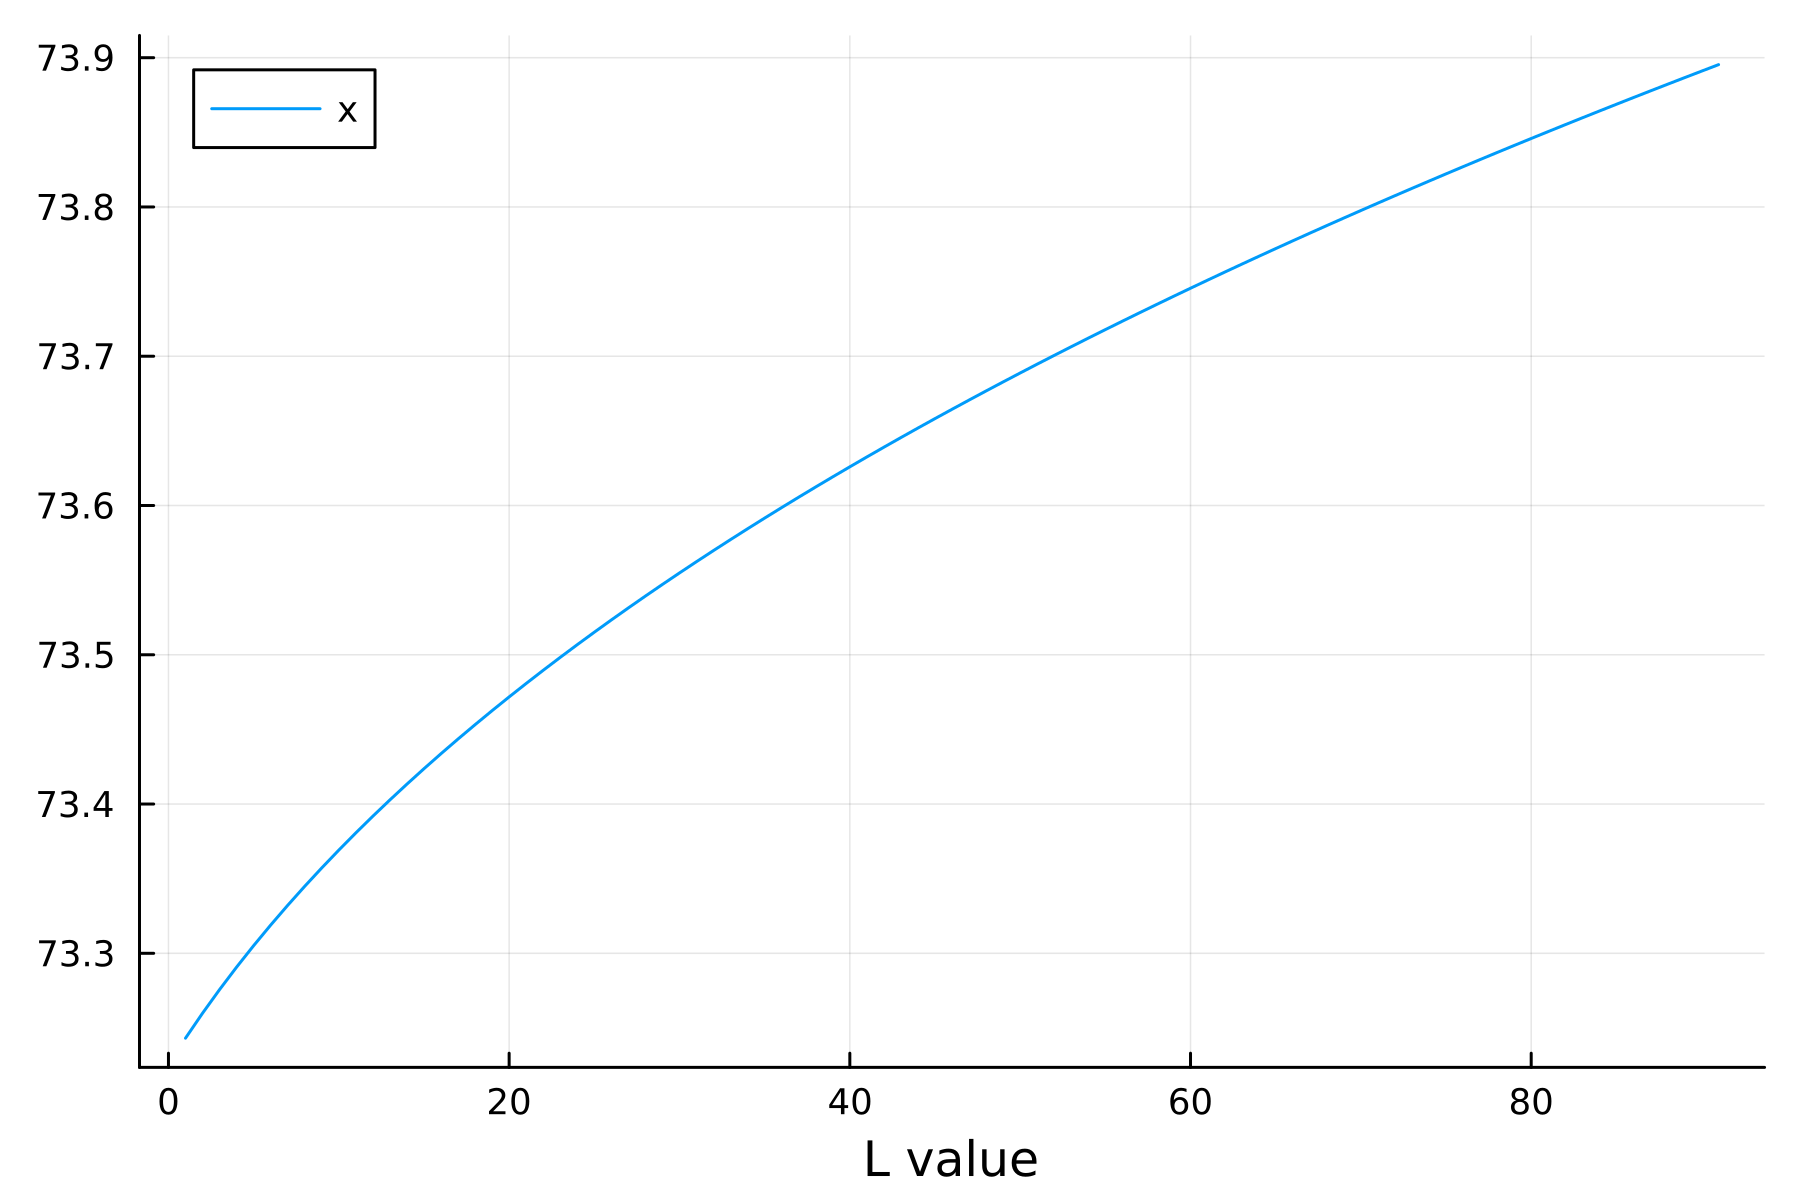

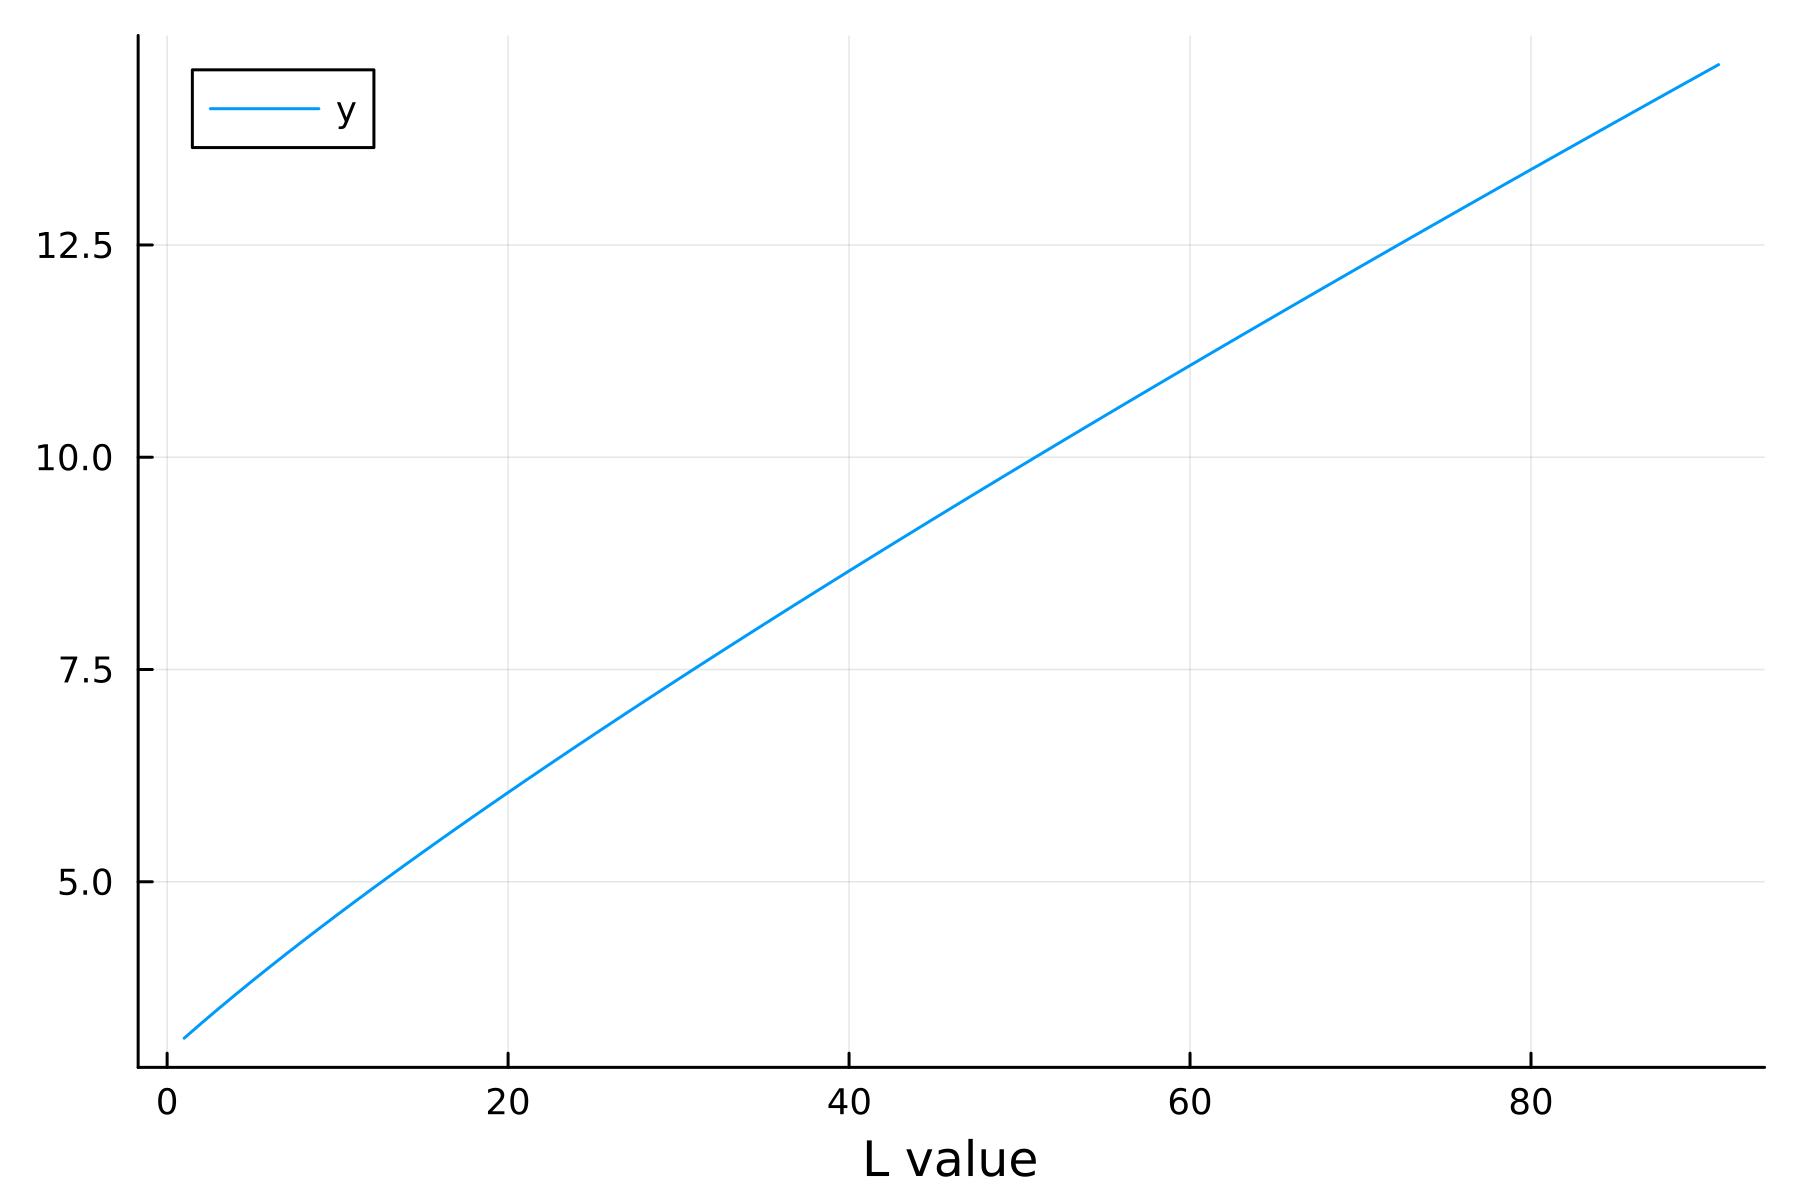

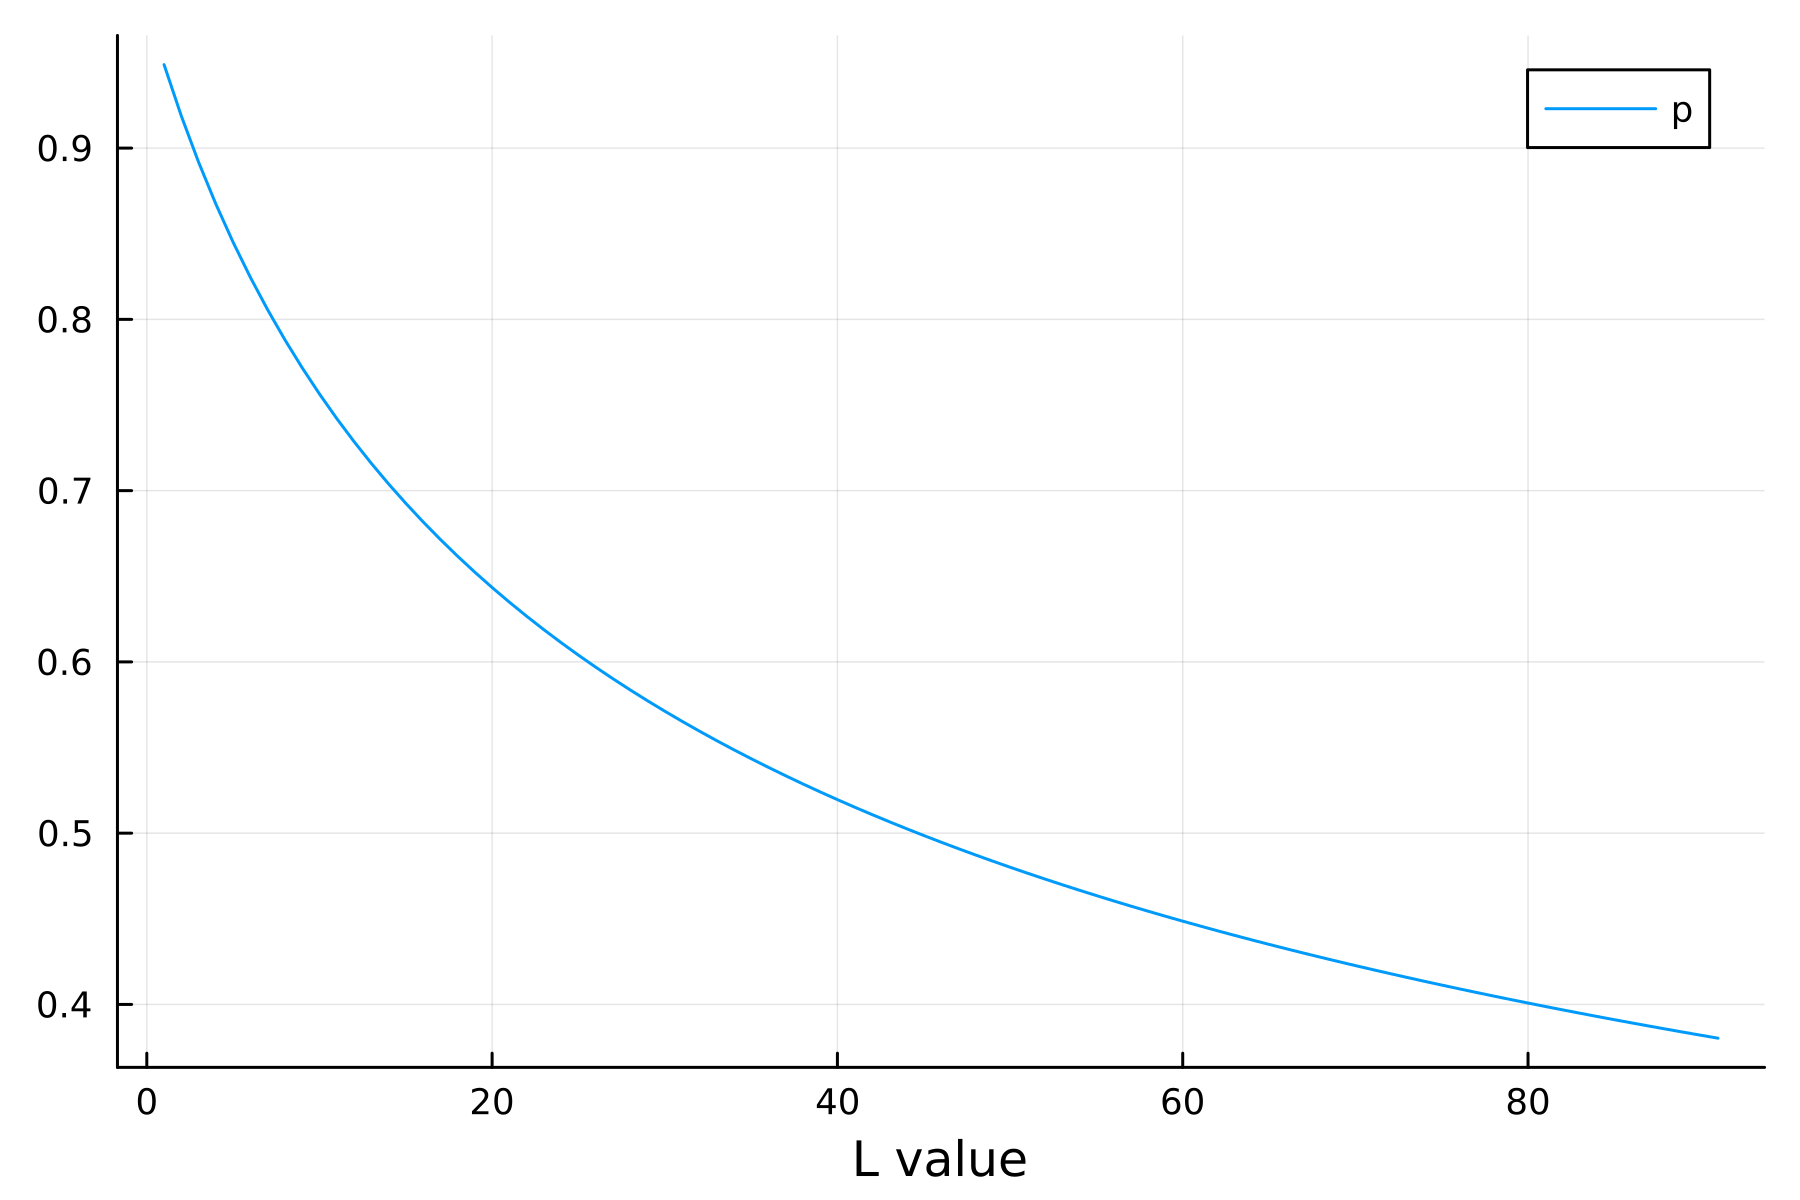

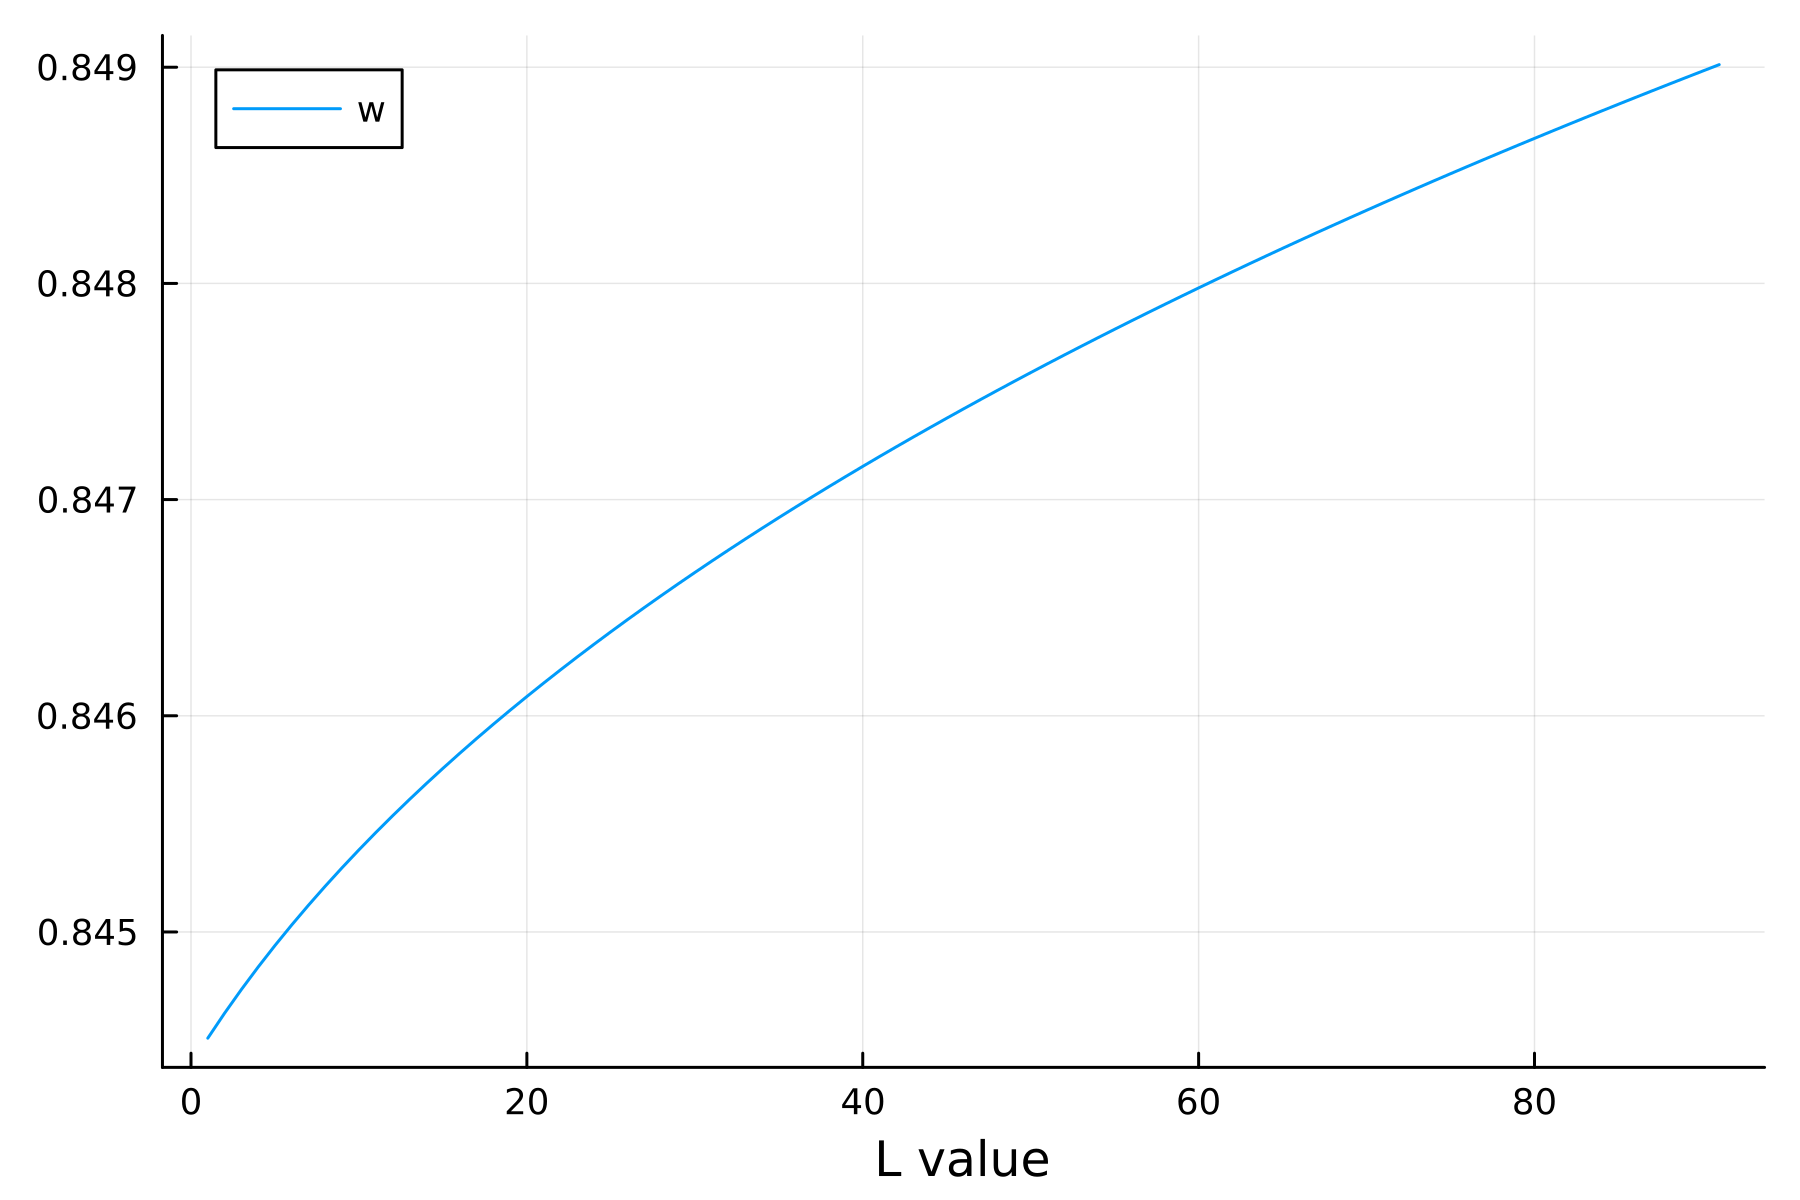

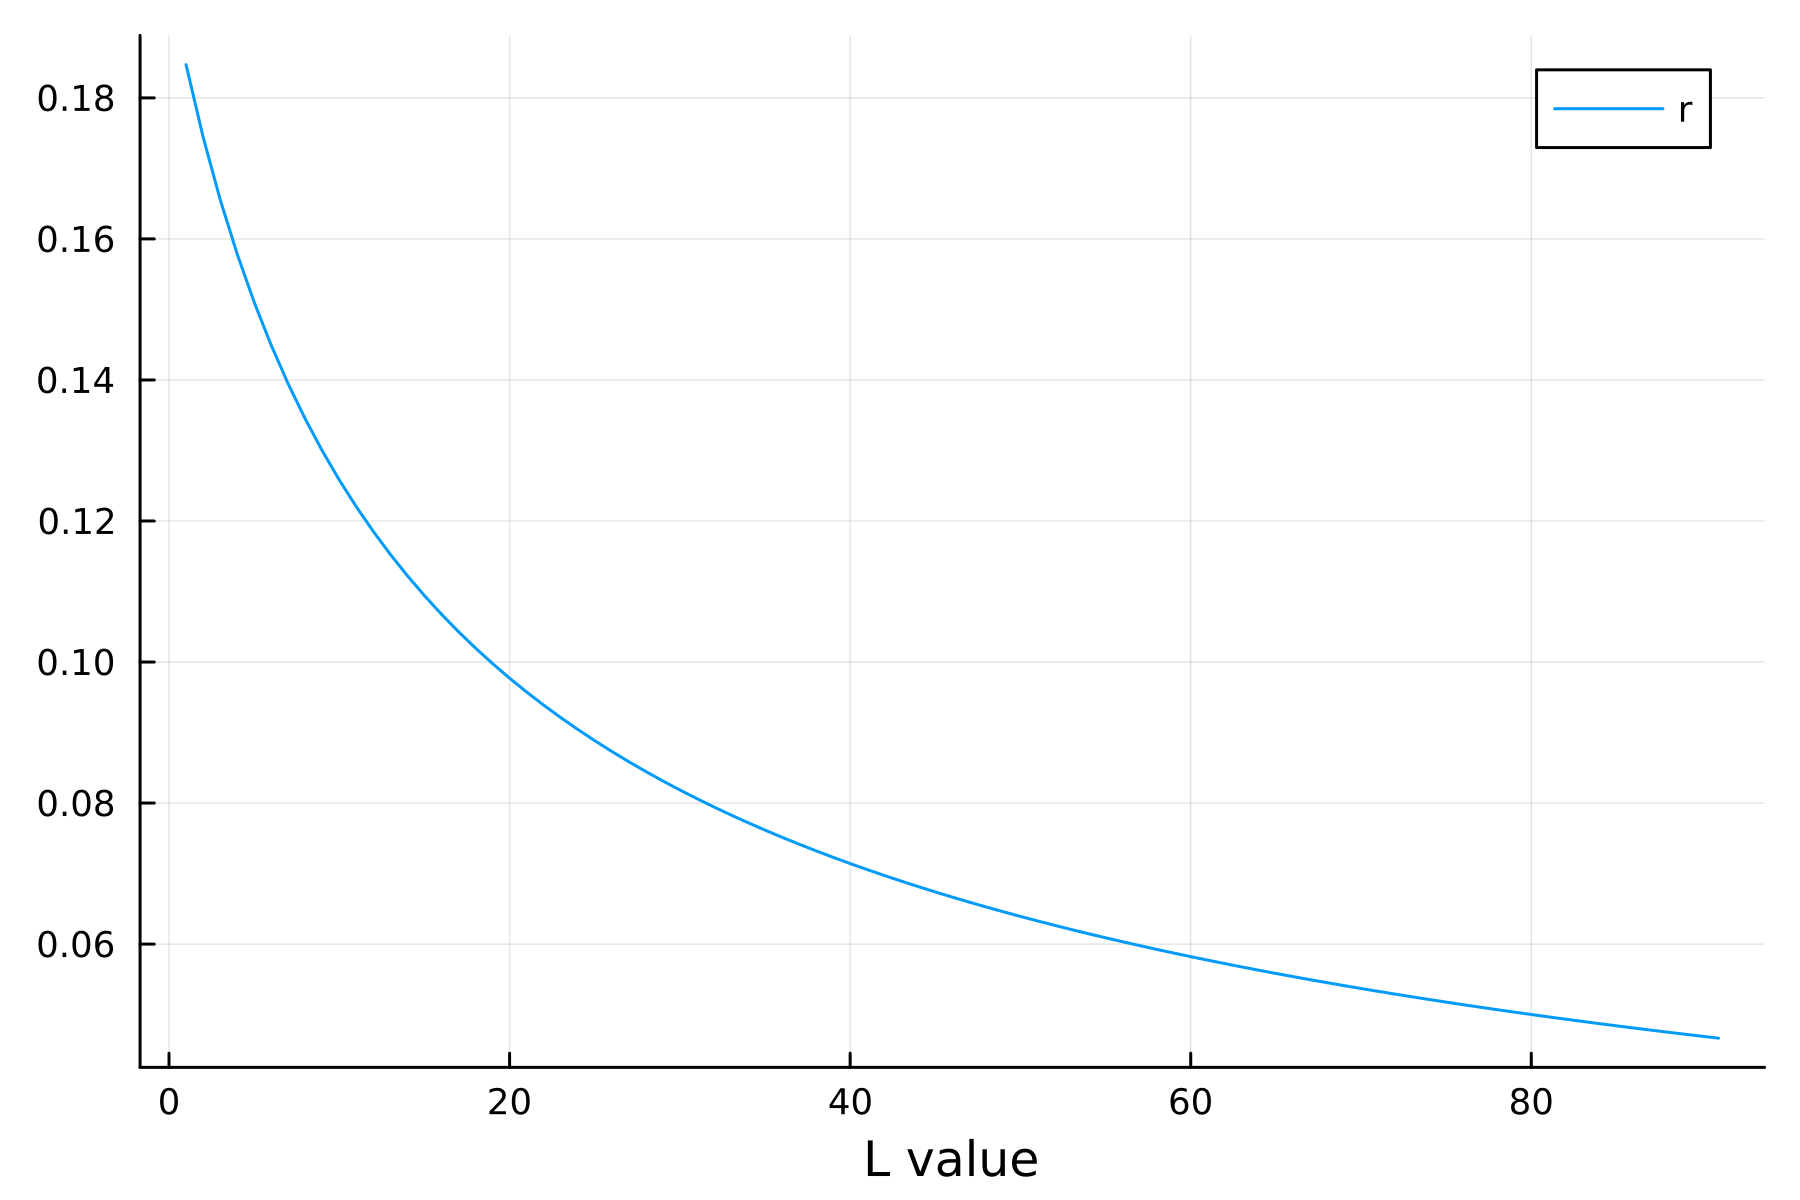

In [4]:
var_labs =  ["x" "y" "p" "w" "r" "λ" "L_x" "L_y" "N" "N_x" "N_y" "K" "K_x" "K_y"]
foc_labs = ["walras_law" "l_mkt_clearing" "n_mkt_clearing" "k_mkt_clearing" "π_x" "π_y" "π_total" "λ" "∂x/∂N_x - w" "p*∂y/∂N_y - w" "∂x/∂L_x - r" "p*∂y/∂L_y - r" "∂x/∂K_x - ι" "p*∂y/∂K_y - ι"]

scale_max = 100.0
scaledown_choice = "L"
# as previously mentioned, numerical stability breaks down eventually around scale ~= 1/10 * scale_max
# use this "well_behaved_flag" to restrict domain to the "well-behaved" region
L_success, L_solution_matrix, L_convergence_matrix = asymmetric_scale(scaledown_choice, scale_max)

domain = 1:91

for j in 1:5
    p = Plots.plot(reverse(L_solution_matrix[j,domain]), 
            xlabel = "L value", 
            ylabel = "", 
            label = var_labs[j],
            dpi = 300)
    display(p) # required to show plot inside a loop
    sleep(0.5)
end

Now we will look at how those prices and quantities respond to scaling $N_T$ from 1 to 100. For this exercise, fixed land supply is held at $\bar{L} = 100$.

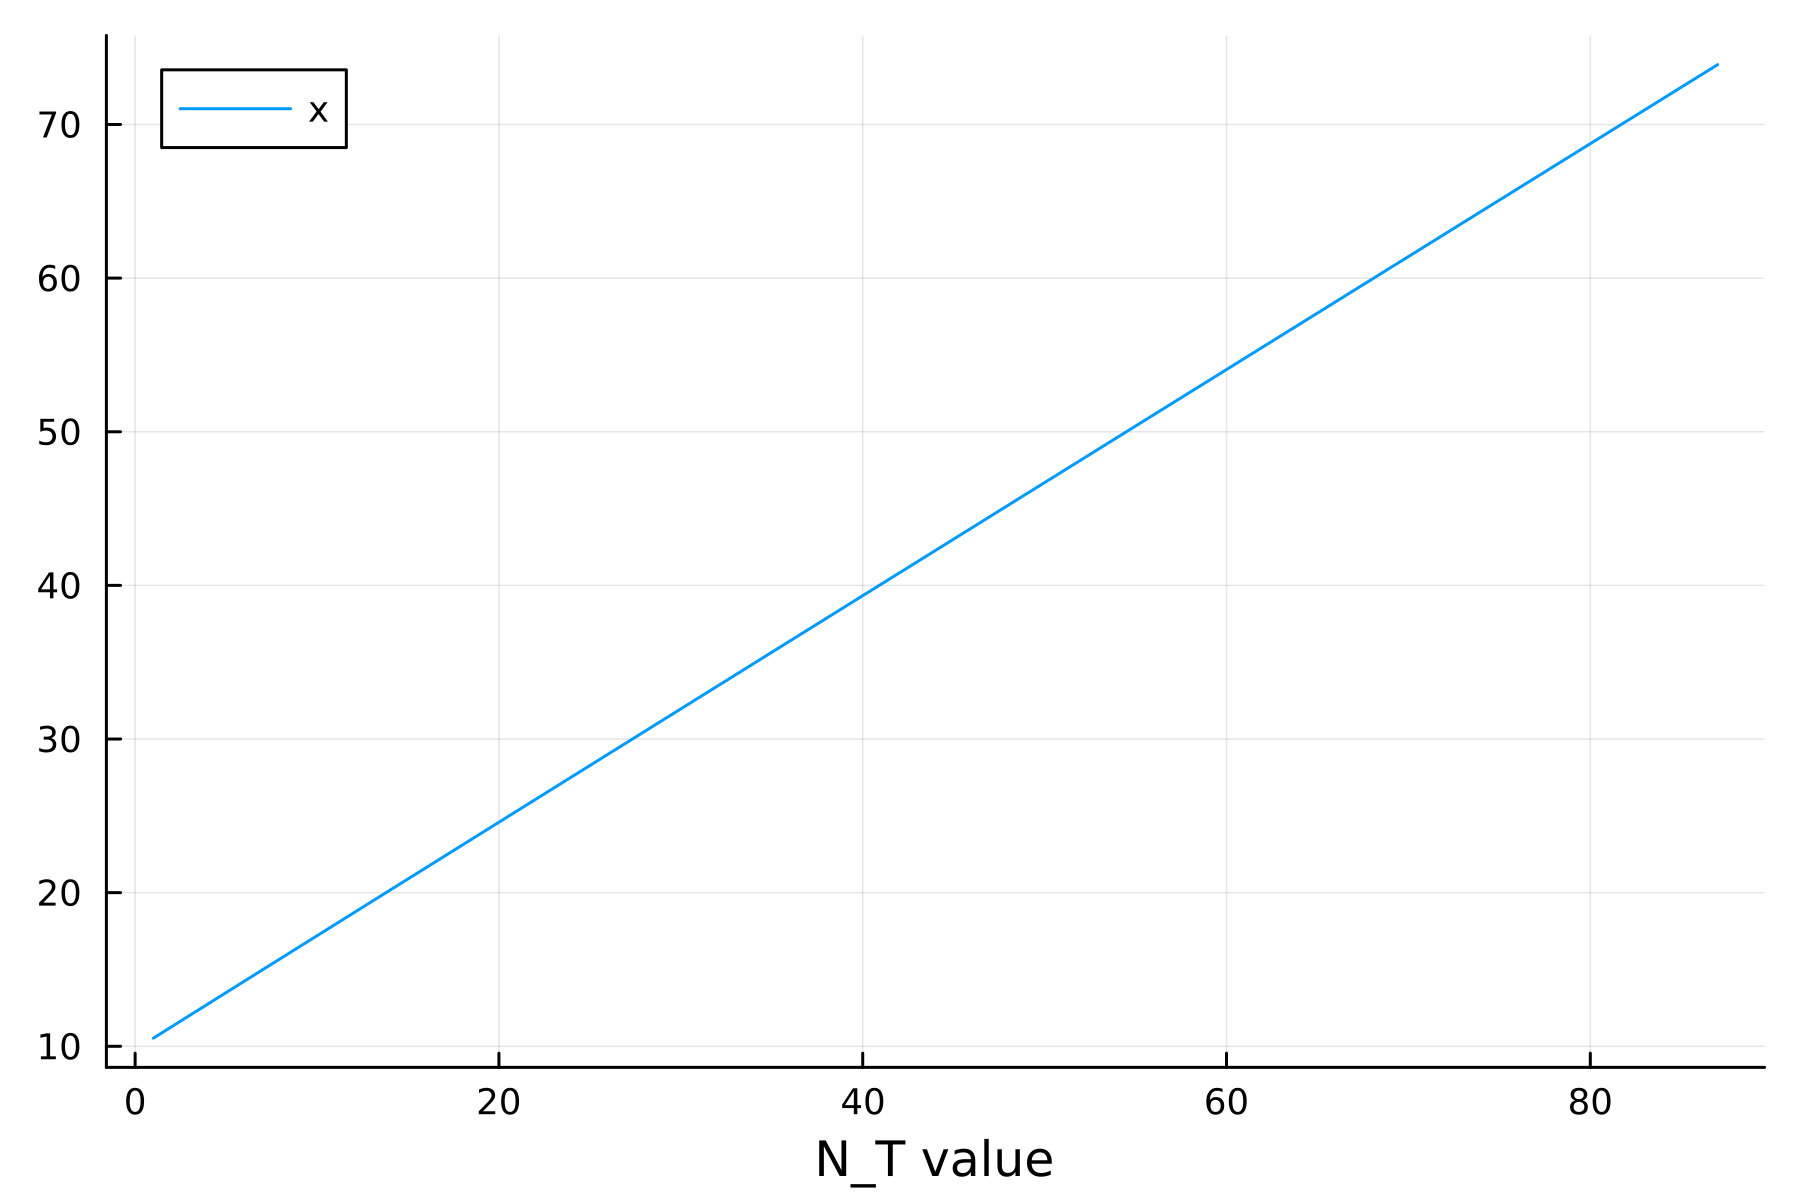

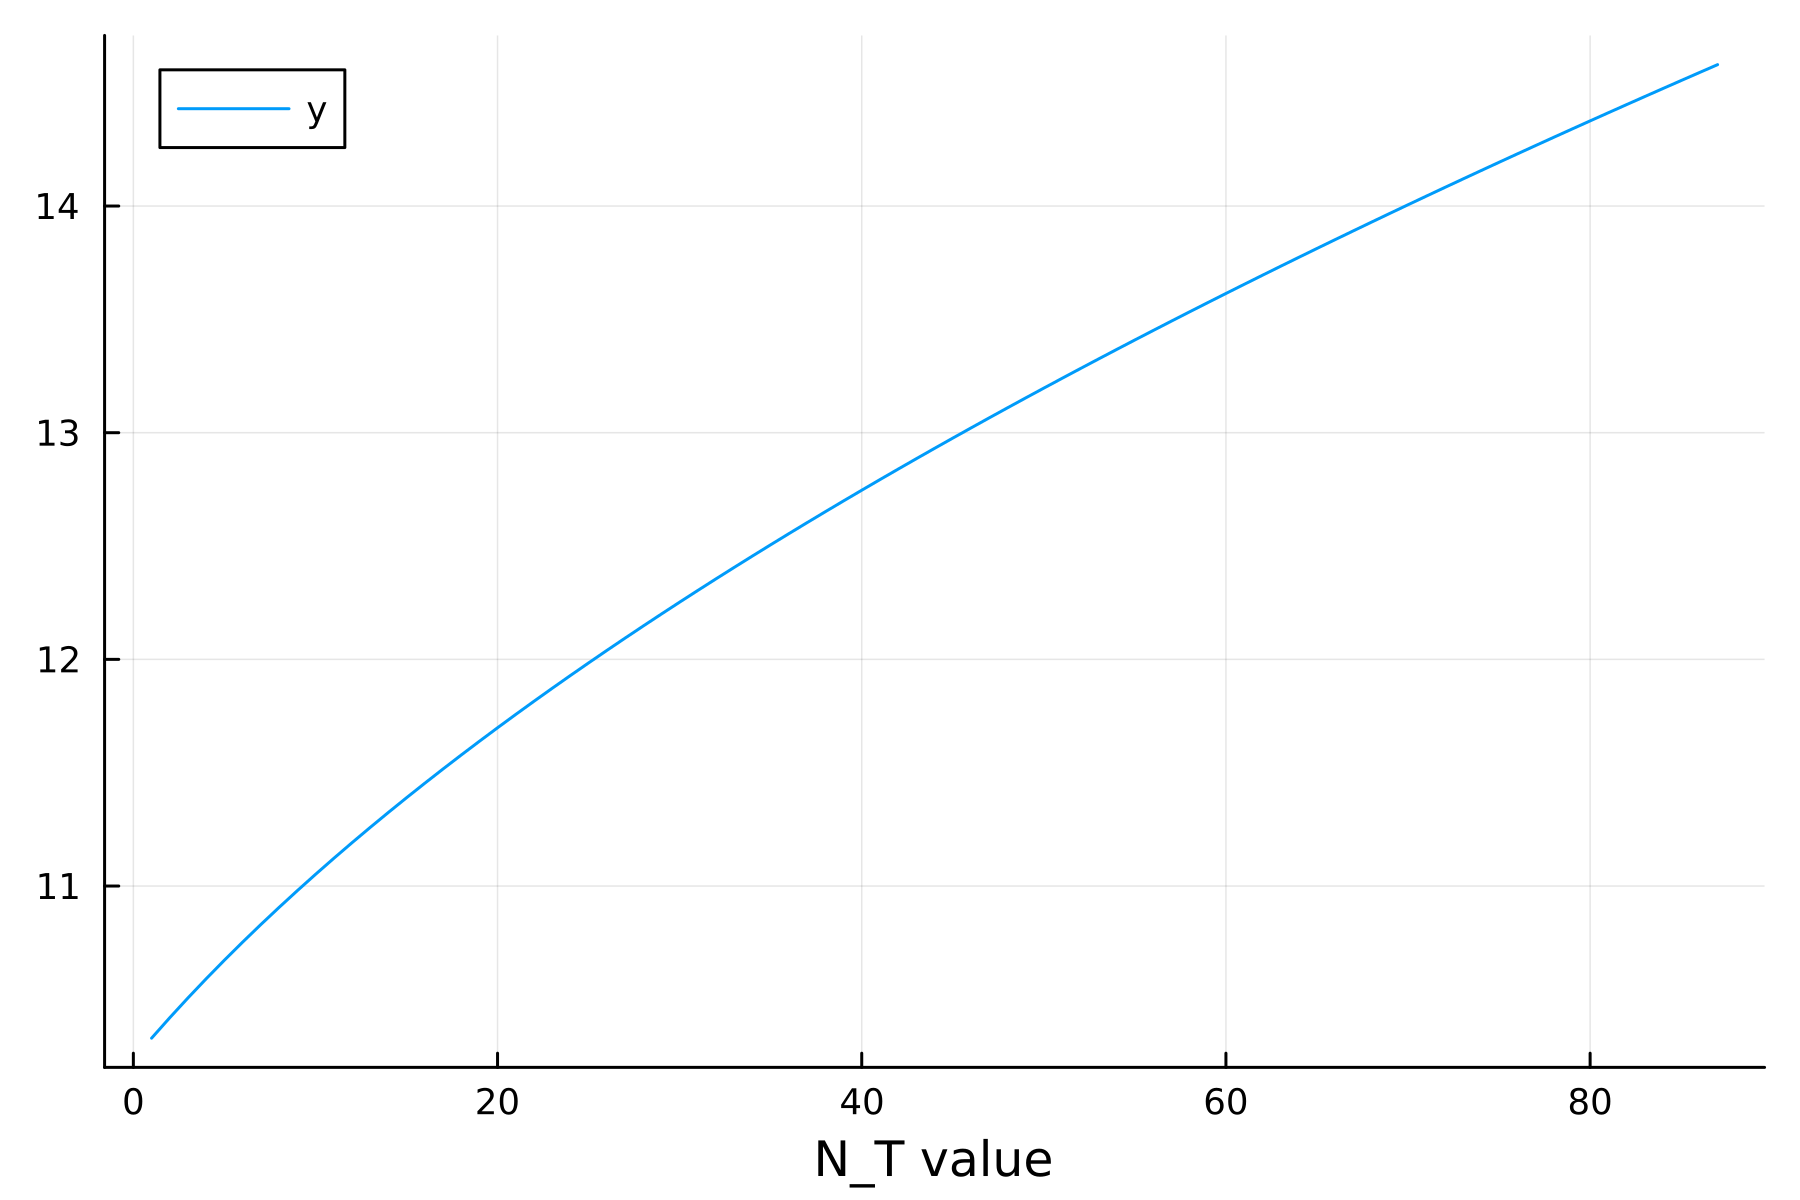

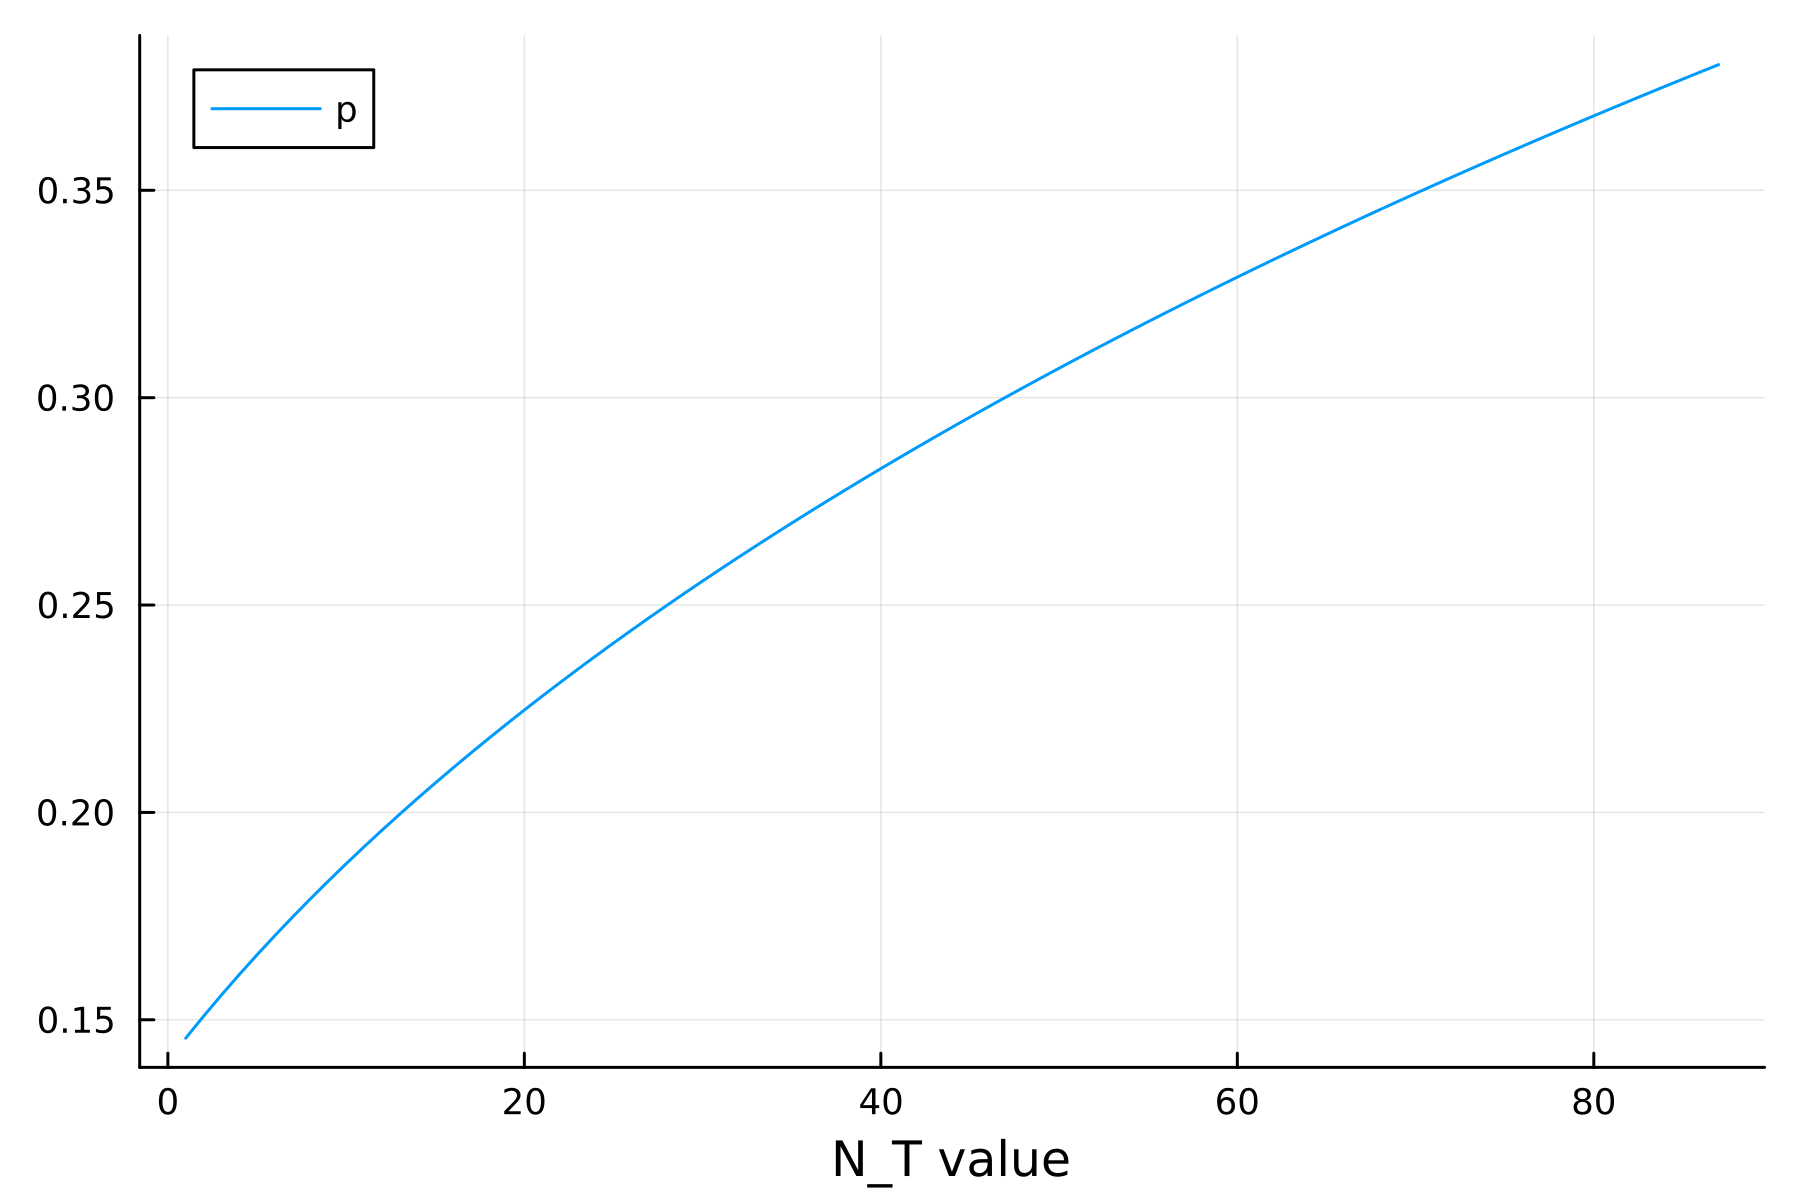

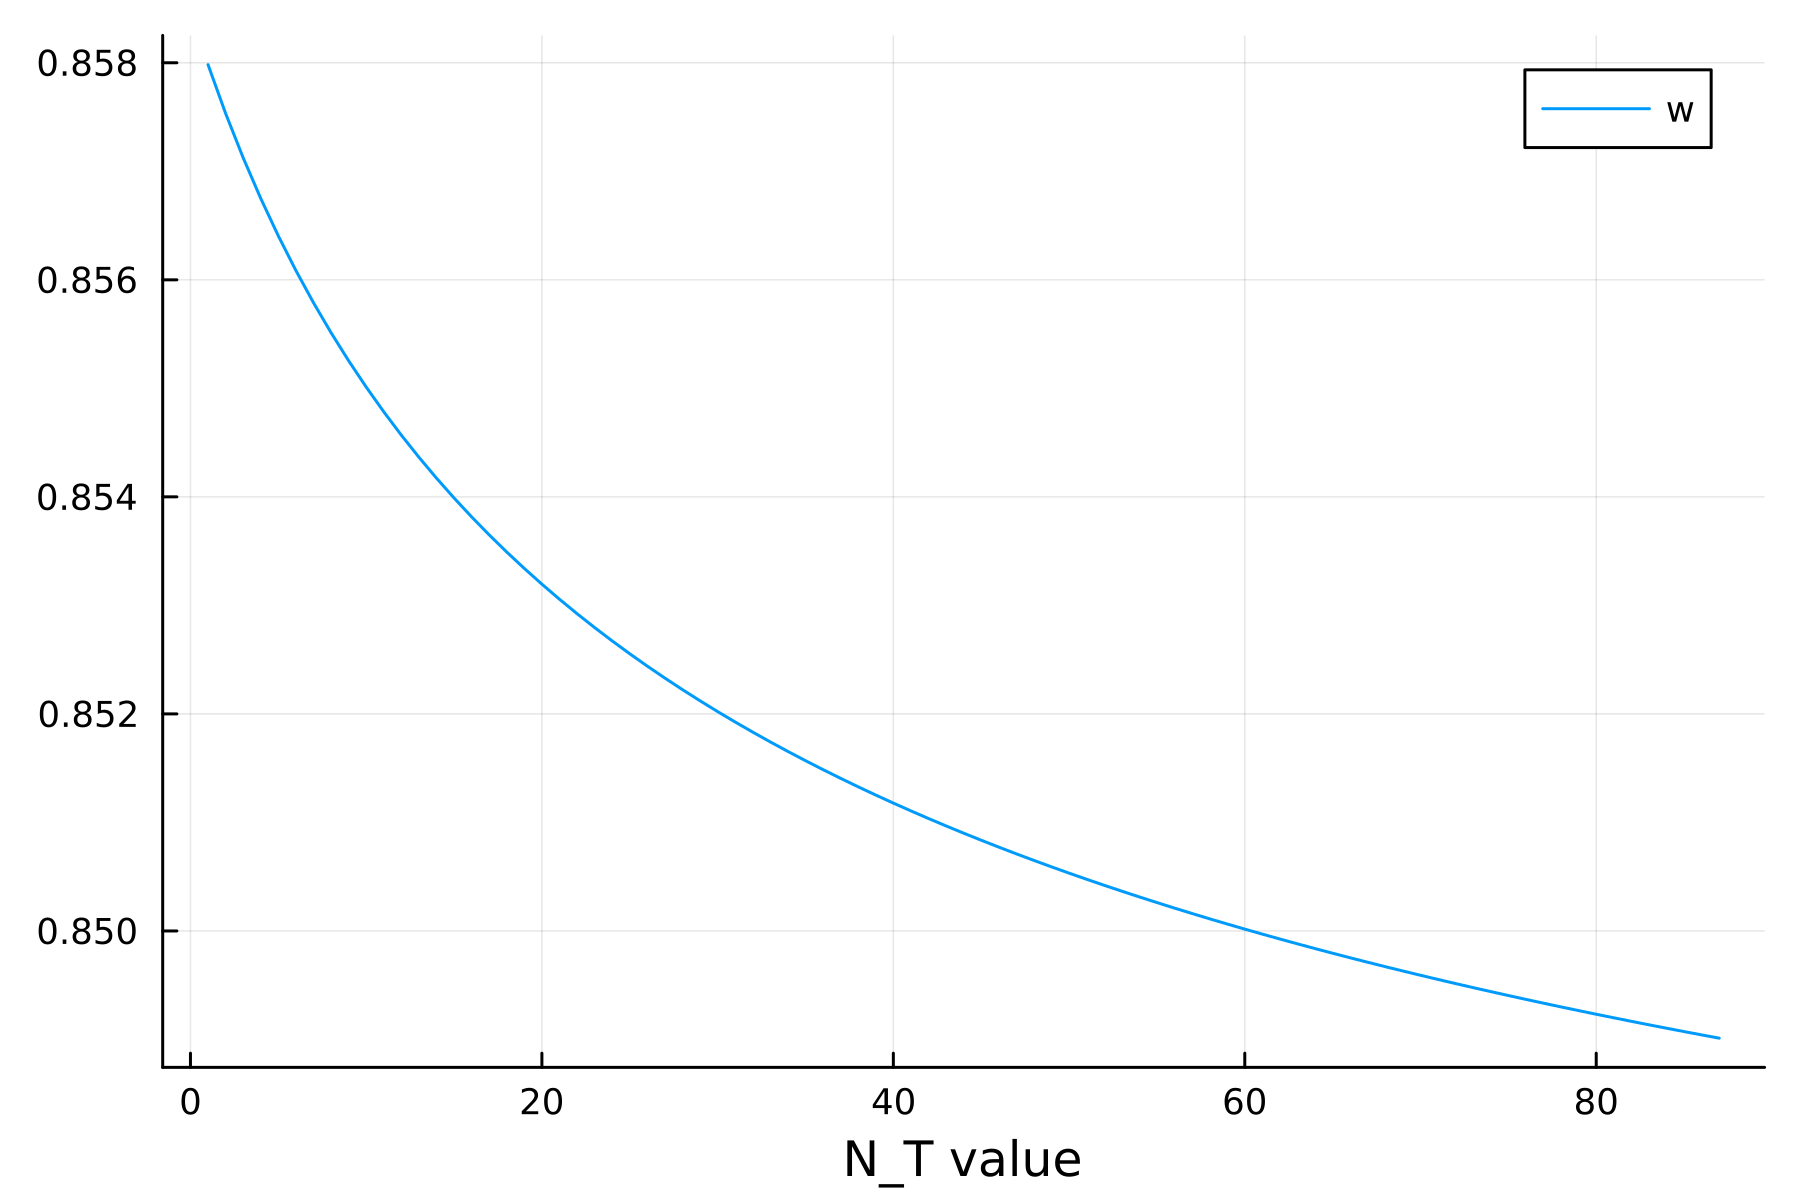

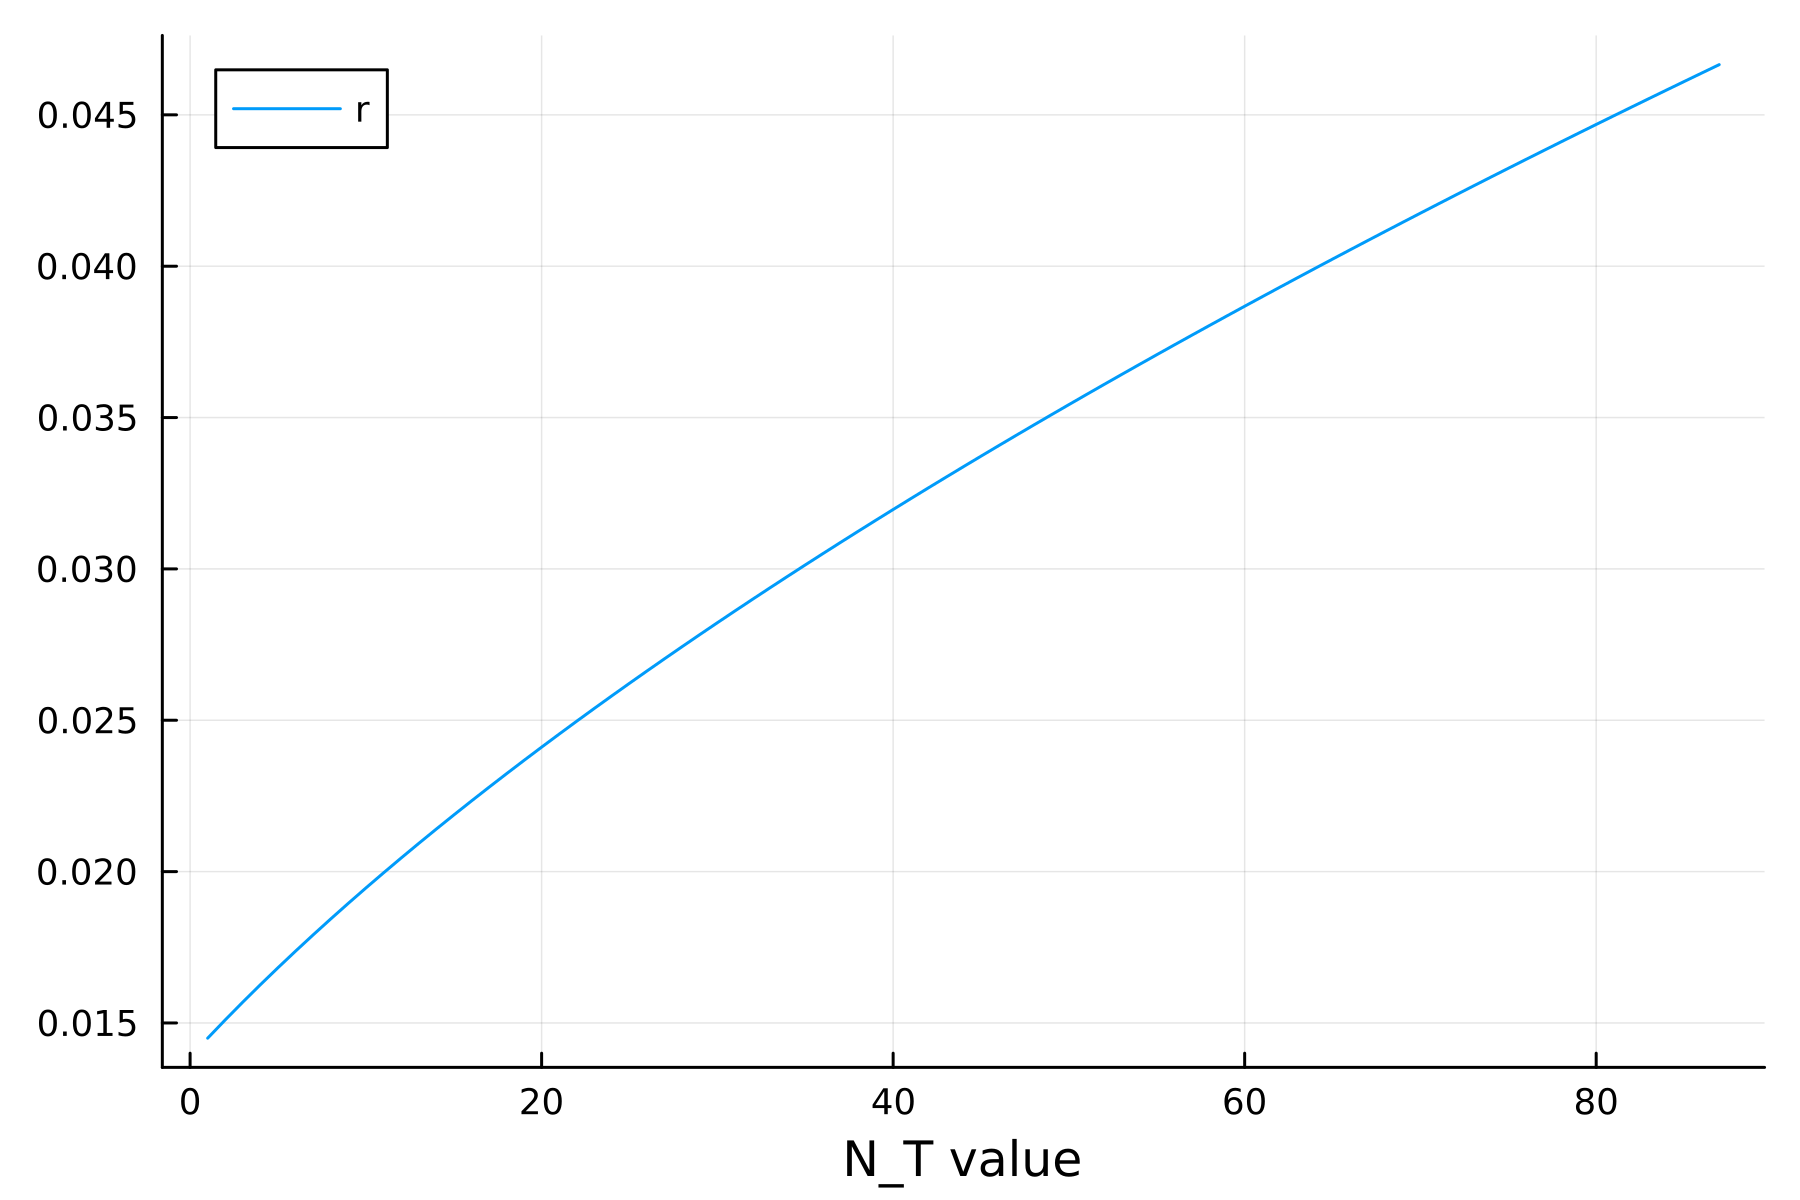

In [5]:
scaledown_choice = "N_T"

N_success, N_solution_matrix, N_convergence_matrix = asymmetric_scale(scaledown_choice, scale_max)

domain = 1:87 # "well-behaved" region for N_T

for j in 1:5
    p = Plots.plot(reverse(N_solution_matrix[j,domain]), 
            xlabel = "N_T value", 
            ylabel = "", 
            label = var_labs[j],
            dpi = 300)
    display(p) # required to show plot inside a loop
    sleep(0.5)
end

We see certain familiar results resembling the partial equilibrium case; as the fixed supply of factors are expanded, their prices go down. In this more-advanced model, though, it takes seconds see not only the own-price impact, but also the impact on both output goods and the prices of the other 2 factors. Based on the substitution parameters, more of one factor raises the productivity of other factors at the margin, and their prices go up. It's possible to change some of the model parameters and see how that impacts the results.

One of the more interesting things about this model are the different ways agents transact in factor markets. Households provide variable labor, which has a direct utility cost, but they also rent-out a fixed supply of land, and capital which is variable but has a fixed price. Firms can flexibly obtain labor and capital up to a point, but they need to negotiate a split of the total, fixed land supply amongst themselves. Not to mention how the stock of capital responds to changes in the fixed supplies of other factors; see below.

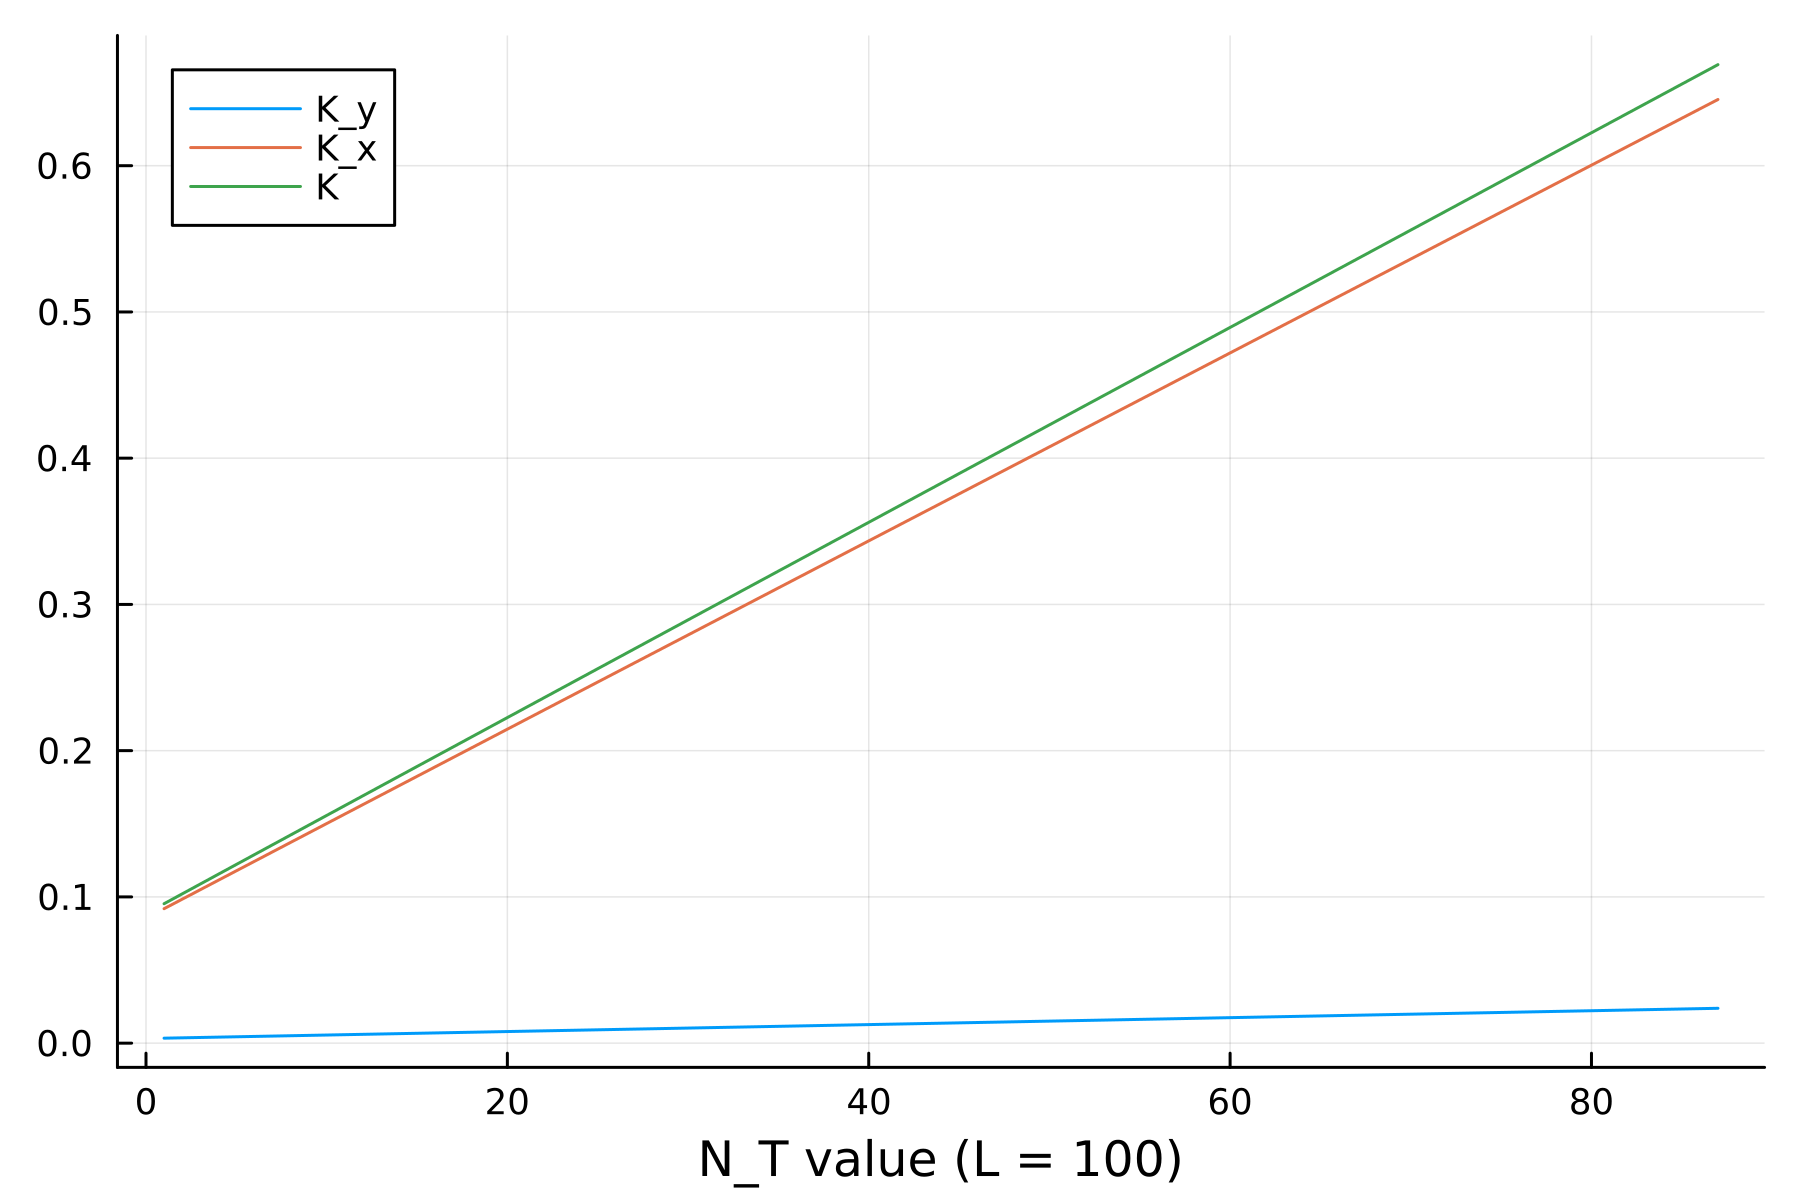

In [30]:
Plots.plot(reverse(N_solution_matrix[12:14,domain]'), 
    xlabel = "N_T value (L = 100)", 
    ylabel = "", 
    label = reverse(permutedims(var_labs[12:14])),
    dpi = 300)

Capital starts at a very low level and quickly scales-up linearly when the maximum amount of labor-hours is increased.

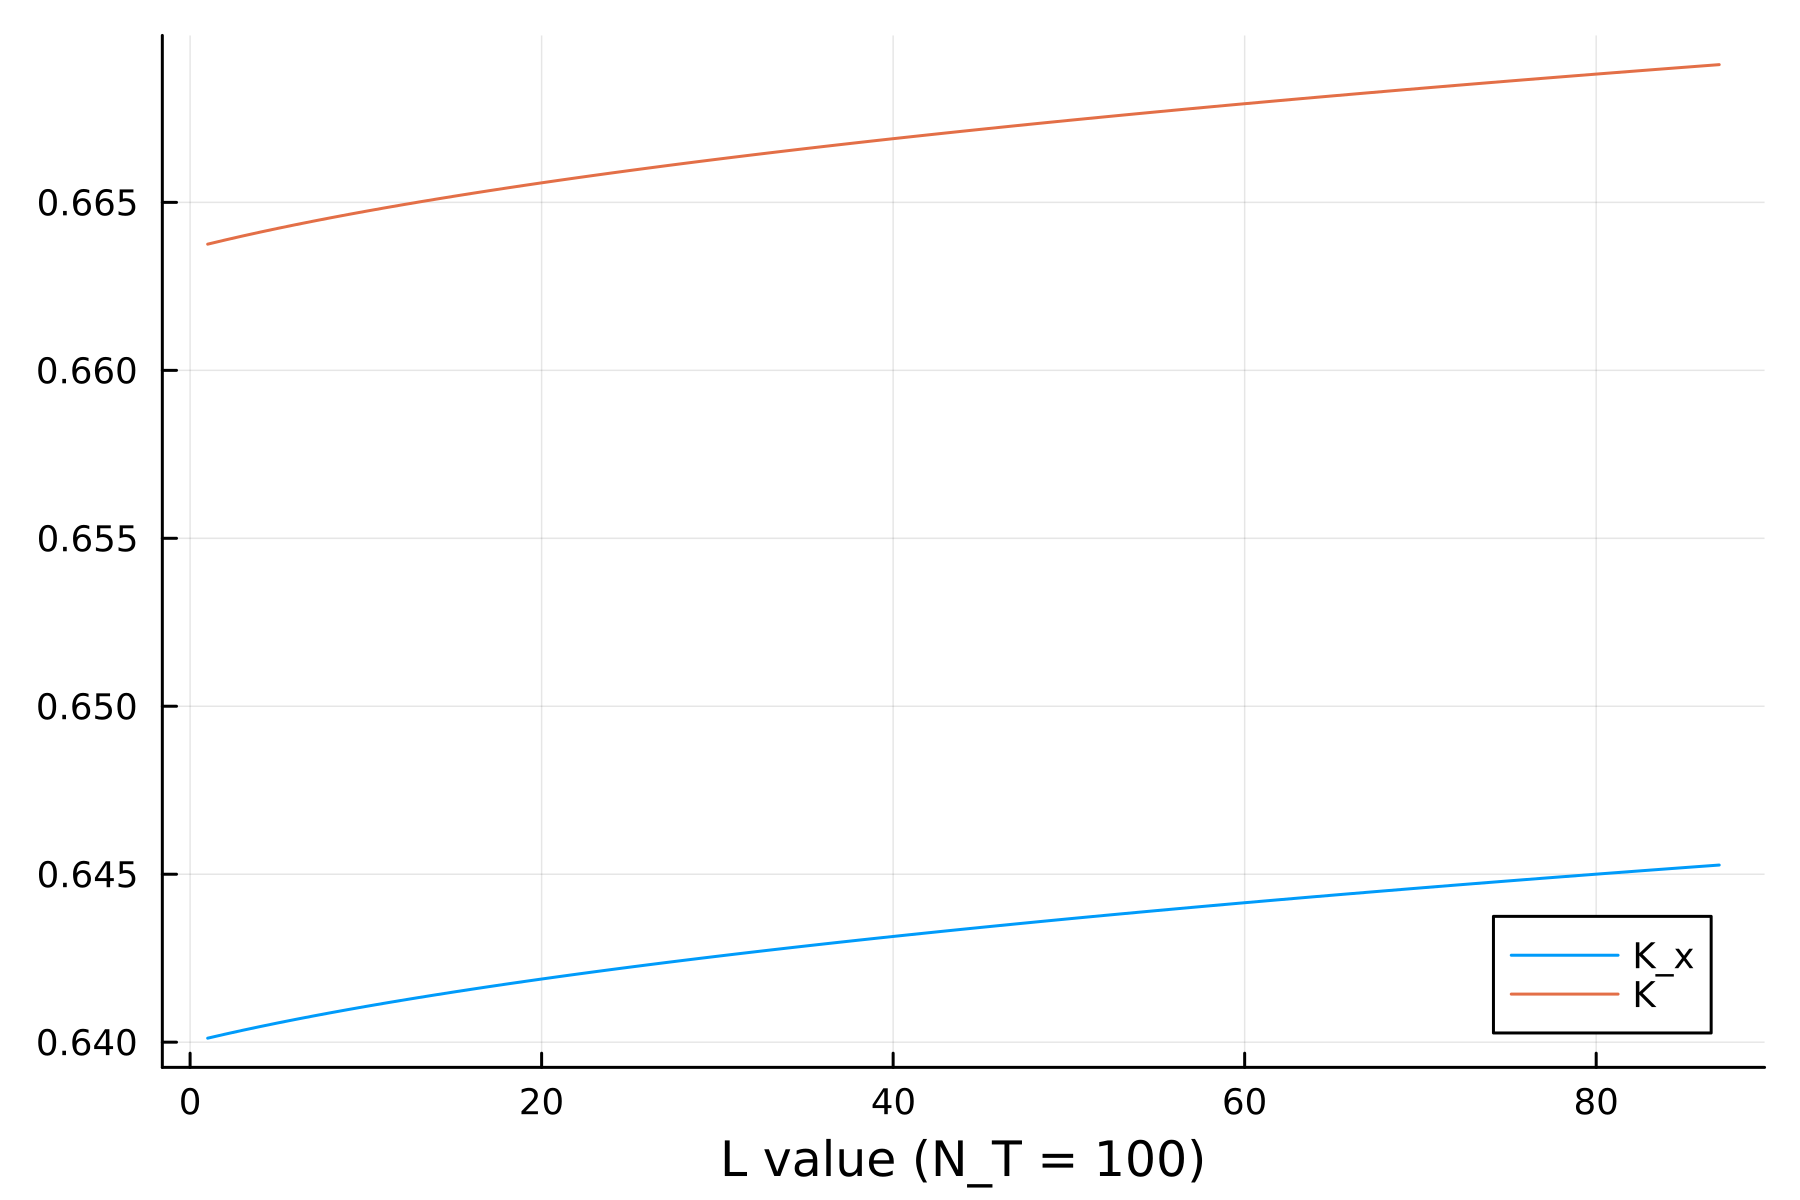

In [46]:
Plots.plot(reverse(L_solution_matrix[12:13,domain]'), 
    xlabel = "L value (N_T = 100)", 
    ylabel = "", 
    label = reverse(permutedims(var_labs[12:13])),
    dpi = 300)

Even though capital starts out at a much higher level when land starts out more-scarce compared to labor, it barely changes whatsoever. Including $K_x$ in the plot makes the difference nearly imperceptible. To the extent that increases at all, it does so in a more convex way.

## Reflections


This model is obviously more flexible and potentially more realistic than simpler models, but the possibilities for extending it are practically limitless. The most feasible, reasonable accommodations would preserve the static nature of the model. A logical next step would be adding a second household-- then, stepping further, there may be a government which levies taxes and redistributes the revenues across households. This would offer a lot of flexibility, and be very useful for policy analysis. Lastly, while it may take some effort, moving towards a dynamic model could have capital be accumulated from investment decisions by households, like in an [Overlapping Generations model](https://en.wikipedia.org/wiki/Overlapping_generations_model).